In [1]:
# coding: utf-8

# In[1]:


from __future__ import print_function, division

from keras.datasets import fashion_mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU

import matplotlib.pyplot as plt
import sys
import numpy as np


Using TensorFlow backend.


In [2]:


# In[2]:


class GAN():
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)


    def build_generator(self):

        model = Sequential()

        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        #model.add(Dense(2048))
        #model.add(LeakyReLU(alpha=0.2))
        #model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Flatten(input_shape=self.img_shape))
        #model.add(Dense(512))
        #model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
        (X_train, _), (_, _) = fashion_mnist.load_data()

        # Rescale -1 to 1
        X_train = X_train / 127.5 - 1.
        X_train = np.expand_dims(X_train, axis=3)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Generate a batch of new images
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Train the generator (to have the discriminator label samples as valid)
            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        #fig.savefig("images/%d.png" % epoch)
        plt.show()
        plt.close()




_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_________________________________________________________________
____

C:\Users\angelsan\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\engine\training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.617035, acc.: 49.00%] [G loss: 0.350030]


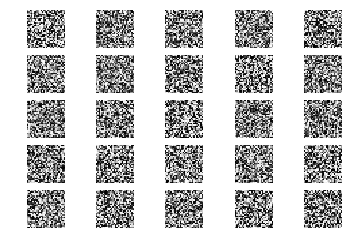

1 [D loss: 0.779478, acc.: 51.00%] [G loss: 0.387999]
2 [D loss: 0.601566, acc.: 53.00%] [G loss: 0.521454]
3 [D loss: 0.469241, acc.: 61.00%] [G loss: 0.674969]
4 [D loss: 0.406317, acc.: 73.00%] [G loss: 0.831279]
5 [D loss: 0.339380, acc.: 82.00%] [G loss: 0.900136]
6 [D loss: 0.269823, acc.: 92.00%] [G loss: 1.089905]
7 [D loss: 0.256950, acc.: 95.00%] [G loss: 1.131462]
8 [D loss: 0.230972, acc.: 97.00%] [G loss: 1.223975]
9 [D loss: 0.193562, acc.: 98.00%] [G loss: 1.370103]
10 [D loss: 0.186012, acc.: 99.00%] [G loss: 1.465318]
11 [D loss: 0.160799, acc.: 99.00%] [G loss: 1.583918]
12 [D loss: 0.147179, acc.: 100.00%] [G loss: 1.606847]
13 [D loss: 0.134875, acc.: 100.00%] [G loss: 1.729210]
14 [D loss: 0.130599, acc.: 100.00%] [G loss: 1.718169]
15 [D loss: 0.117908, acc.: 100.00%] [G loss: 1.890059]
16 [D loss: 0.105100, acc.: 100.00%] [G loss: 1.905289]
17 [D loss: 0.102226, acc.: 100.00%] [G loss: 1.972929]
18 [D loss: 0.100678, acc.: 100.00%] [G loss: 2.156786]
19 [D loss: 

148 [D loss: 0.167122, acc.: 97.00%] [G loss: 3.460603]
149 [D loss: 0.361752, acc.: 84.00%] [G loss: 2.591634]
150 [D loss: 0.216823, acc.: 91.00%] [G loss: 3.858576]
151 [D loss: 0.656815, acc.: 71.00%] [G loss: 2.511055]
152 [D loss: 0.328567, acc.: 83.00%] [G loss: 3.409038]
153 [D loss: 0.492862, acc.: 77.00%] [G loss: 3.183296]
154 [D loss: 0.217329, acc.: 95.00%] [G loss: 3.248807]
155 [D loss: 0.324867, acc.: 86.00%] [G loss: 2.845294]
156 [D loss: 0.337710, acc.: 84.00%] [G loss: 3.102141]
157 [D loss: 0.310213, acc.: 90.00%] [G loss: 2.810031]
158 [D loss: 0.450302, acc.: 80.00%] [G loss: 2.944468]
159 [D loss: 0.374639, acc.: 85.00%] [G loss: 2.722365]
160 [D loss: 0.334501, acc.: 85.00%] [G loss: 2.389334]
161 [D loss: 0.449484, acc.: 79.00%] [G loss: 3.391846]
162 [D loss: 1.368969, acc.: 53.00%] [G loss: 1.990394]
163 [D loss: 0.437910, acc.: 75.00%] [G loss: 2.912997]
164 [D loss: 0.257720, acc.: 93.00%] [G loss: 3.284288]
165 [D loss: 0.509694, acc.: 84.00%] [G loss: 1.

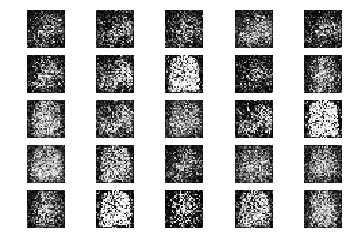

201 [D loss: 0.688165, acc.: 63.00%] [G loss: 1.732003]
202 [D loss: 0.557276, acc.: 66.00%] [G loss: 2.286207]
203 [D loss: 0.569762, acc.: 77.00%] [G loss: 2.113518]
204 [D loss: 0.670509, acc.: 74.00%] [G loss: 1.885258]
205 [D loss: 0.621356, acc.: 69.00%] [G loss: 1.717638]
206 [D loss: 0.610051, acc.: 71.00%] [G loss: 1.922462]
207 [D loss: 0.556453, acc.: 69.00%] [G loss: 1.821445]
208 [D loss: 0.676181, acc.: 57.00%] [G loss: 1.778836]
209 [D loss: 0.804027, acc.: 51.00%] [G loss: 1.563435]
210 [D loss: 0.459836, acc.: 78.00%] [G loss: 2.084258]
211 [D loss: 0.638044, acc.: 63.00%] [G loss: 1.691851]
212 [D loss: 0.572638, acc.: 66.00%] [G loss: 1.650356]
213 [D loss: 0.587764, acc.: 69.00%] [G loss: 1.952515]
214 [D loss: 0.691797, acc.: 57.00%] [G loss: 1.692210]
215 [D loss: 0.570324, acc.: 70.00%] [G loss: 1.885419]
216 [D loss: 0.491757, acc.: 78.00%] [G loss: 1.811925]
217 [D loss: 0.592771, acc.: 71.00%] [G loss: 1.470757]
218 [D loss: 0.647803, acc.: 59.00%] [G loss: 1.

348 [D loss: 0.618333, acc.: 65.00%] [G loss: 0.936109]
349 [D loss: 0.608926, acc.: 64.00%] [G loss: 0.961136]
350 [D loss: 0.593939, acc.: 64.00%] [G loss: 0.965429]
351 [D loss: 0.623757, acc.: 61.00%] [G loss: 0.897885]
352 [D loss: 0.578435, acc.: 69.00%] [G loss: 0.990356]
353 [D loss: 0.571446, acc.: 72.00%] [G loss: 1.003928]
354 [D loss: 0.618499, acc.: 66.00%] [G loss: 0.986006]
355 [D loss: 0.584027, acc.: 64.00%] [G loss: 1.019089]
356 [D loss: 0.617012, acc.: 68.00%] [G loss: 0.941354]
357 [D loss: 0.594395, acc.: 65.00%] [G loss: 0.941253]
358 [D loss: 0.628500, acc.: 60.00%] [G loss: 0.869559]
359 [D loss: 0.643126, acc.: 60.00%] [G loss: 0.965259]
360 [D loss: 0.606308, acc.: 62.00%] [G loss: 0.972587]
361 [D loss: 0.594653, acc.: 71.00%] [G loss: 1.067480]
362 [D loss: 0.638066, acc.: 62.00%] [G loss: 1.005814]
363 [D loss: 0.556823, acc.: 72.00%] [G loss: 1.037832]
364 [D loss: 0.581648, acc.: 69.00%] [G loss: 0.965652]
365 [D loss: 0.581556, acc.: 68.00%] [G loss: 1.

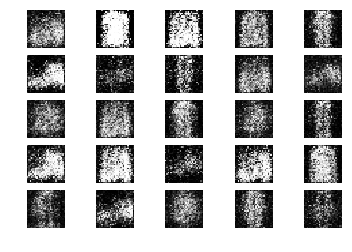

401 [D loss: 0.627457, acc.: 68.00%] [G loss: 0.934031]
402 [D loss: 0.718242, acc.: 53.00%] [G loss: 0.875843]
403 [D loss: 0.674267, acc.: 55.00%] [G loss: 0.843733]
404 [D loss: 0.692040, acc.: 49.00%] [G loss: 0.807439]
405 [D loss: 0.680167, acc.: 53.00%] [G loss: 0.815620]
406 [D loss: 0.688236, acc.: 65.00%] [G loss: 0.810014]
407 [D loss: 0.716013, acc.: 54.00%] [G loss: 0.854558]
408 [D loss: 0.673971, acc.: 59.00%] [G loss: 0.895844]
409 [D loss: 0.710565, acc.: 56.00%] [G loss: 0.825346]
410 [D loss: 0.683129, acc.: 51.00%] [G loss: 0.846024]
411 [D loss: 0.694129, acc.: 53.00%] [G loss: 0.785112]
412 [D loss: 0.697552, acc.: 53.00%] [G loss: 0.789120]
413 [D loss: 0.638566, acc.: 67.00%] [G loss: 0.785921]
414 [D loss: 0.668992, acc.: 61.00%] [G loss: 0.797646]
415 [D loss: 0.700820, acc.: 49.00%] [G loss: 0.815659]
416 [D loss: 0.672491, acc.: 54.00%] [G loss: 0.817656]
417 [D loss: 0.674060, acc.: 53.00%] [G loss: 0.758673]
418 [D loss: 0.697378, acc.: 51.00%] [G loss: 0.

549 [D loss: 0.655152, acc.: 55.00%] [G loss: 0.853059]
550 [D loss: 0.631165, acc.: 60.00%] [G loss: 0.814702]
551 [D loss: 0.646617, acc.: 57.00%] [G loss: 0.801451]
552 [D loss: 0.628693, acc.: 59.00%] [G loss: 0.848745]
553 [D loss: 0.627102, acc.: 67.00%] [G loss: 0.889144]
554 [D loss: 0.636788, acc.: 68.00%] [G loss: 0.823179]
555 [D loss: 0.615781, acc.: 68.00%] [G loss: 0.862013]
556 [D loss: 0.647334, acc.: 62.00%] [G loss: 0.841457]
557 [D loss: 0.580082, acc.: 68.00%] [G loss: 0.872455]
558 [D loss: 0.685301, acc.: 53.00%] [G loss: 0.890554]
559 [D loss: 0.647339, acc.: 66.00%] [G loss: 0.873077]
560 [D loss: 0.633134, acc.: 60.00%] [G loss: 0.857473]
561 [D loss: 0.642092, acc.: 53.00%] [G loss: 0.869427]
562 [D loss: 0.672281, acc.: 55.00%] [G loss: 0.850196]
563 [D loss: 0.663796, acc.: 57.00%] [G loss: 0.855965]
564 [D loss: 0.632387, acc.: 59.00%] [G loss: 0.890734]
565 [D loss: 0.683552, acc.: 55.00%] [G loss: 0.890130]
566 [D loss: 0.627331, acc.: 65.00%] [G loss: 0.

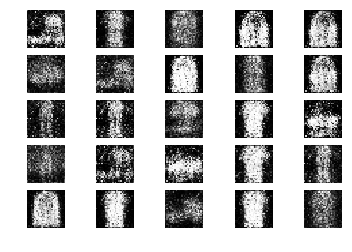

601 [D loss: 0.678141, acc.: 58.00%] [G loss: 0.825889]
602 [D loss: 0.689854, acc.: 49.00%] [G loss: 0.804250]
603 [D loss: 0.592204, acc.: 71.00%] [G loss: 0.803886]
604 [D loss: 0.648413, acc.: 62.00%] [G loss: 0.786322]
605 [D loss: 0.642720, acc.: 69.00%] [G loss: 0.832330]
606 [D loss: 0.625844, acc.: 66.00%] [G loss: 0.901873]
607 [D loss: 0.665316, acc.: 60.00%] [G loss: 0.853092]
608 [D loss: 0.659158, acc.: 61.00%] [G loss: 0.874122]
609 [D loss: 0.631559, acc.: 65.00%] [G loss: 0.917333]
610 [D loss: 0.613831, acc.: 68.00%] [G loss: 0.848563]
611 [D loss: 0.622813, acc.: 71.00%] [G loss: 0.837491]
612 [D loss: 0.629084, acc.: 68.00%] [G loss: 0.855404]
613 [D loss: 0.589961, acc.: 66.00%] [G loss: 0.896038]
614 [D loss: 0.625496, acc.: 70.00%] [G loss: 0.860751]
615 [D loss: 0.629912, acc.: 69.00%] [G loss: 0.844233]
616 [D loss: 0.650522, acc.: 64.00%] [G loss: 0.834466]
617 [D loss: 0.679043, acc.: 64.00%] [G loss: 0.820428]
618 [D loss: 0.649472, acc.: 61.00%] [G loss: 0.

748 [D loss: 0.696658, acc.: 54.00%] [G loss: 0.840566]
749 [D loss: 0.644672, acc.: 66.00%] [G loss: 0.816992]
750 [D loss: 0.645664, acc.: 60.00%] [G loss: 0.776017]
751 [D loss: 0.613503, acc.: 66.00%] [G loss: 0.785543]
752 [D loss: 0.657002, acc.: 61.00%] [G loss: 0.758325]
753 [D loss: 0.638639, acc.: 68.00%] [G loss: 0.744002]
754 [D loss: 0.654848, acc.: 57.00%] [G loss: 0.825811]
755 [D loss: 0.611253, acc.: 67.00%] [G loss: 0.784748]
756 [D loss: 0.666046, acc.: 55.00%] [G loss: 0.823461]
757 [D loss: 0.720180, acc.: 50.00%] [G loss: 0.793398]
758 [D loss: 0.633812, acc.: 62.00%] [G loss: 0.839116]
759 [D loss: 0.608677, acc.: 67.00%] [G loss: 0.830323]
760 [D loss: 0.693535, acc.: 55.00%] [G loss: 0.728785]
761 [D loss: 0.670742, acc.: 54.00%] [G loss: 0.781405]
762 [D loss: 0.634792, acc.: 65.00%] [G loss: 0.785686]
763 [D loss: 0.632706, acc.: 60.00%] [G loss: 0.781881]
764 [D loss: 0.677051, acc.: 63.00%] [G loss: 0.790987]
765 [D loss: 0.630188, acc.: 61.00%] [G loss: 0.

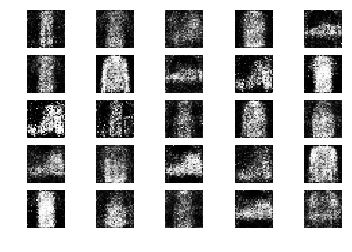

801 [D loss: 0.624865, acc.: 65.00%] [G loss: 0.817169]
802 [D loss: 0.710552, acc.: 45.00%] [G loss: 0.825477]
803 [D loss: 0.683714, acc.: 55.00%] [G loss: 0.769795]
804 [D loss: 0.647620, acc.: 59.00%] [G loss: 0.805787]
805 [D loss: 0.657484, acc.: 59.00%] [G loss: 0.779336]
806 [D loss: 0.649628, acc.: 58.00%] [G loss: 0.791026]
807 [D loss: 0.659159, acc.: 57.00%] [G loss: 0.814721]
808 [D loss: 0.656139, acc.: 63.00%] [G loss: 0.832607]
809 [D loss: 0.628333, acc.: 65.00%] [G loss: 0.783672]
810 [D loss: 0.621823, acc.: 59.00%] [G loss: 0.789768]
811 [D loss: 0.674775, acc.: 55.00%] [G loss: 0.766162]
812 [D loss: 0.649393, acc.: 65.00%] [G loss: 0.798630]
813 [D loss: 0.698190, acc.: 51.00%] [G loss: 0.833194]
814 [D loss: 0.645164, acc.: 60.00%] [G loss: 0.825754]
815 [D loss: 0.607598, acc.: 62.00%] [G loss: 0.864959]
816 [D loss: 0.667182, acc.: 56.00%] [G loss: 0.795757]
817 [D loss: 0.702460, acc.: 52.00%] [G loss: 0.792620]
818 [D loss: 0.662205, acc.: 59.00%] [G loss: 0.

949 [D loss: 0.667048, acc.: 61.00%] [G loss: 0.785447]
950 [D loss: 0.610712, acc.: 66.00%] [G loss: 0.820764]
951 [D loss: 0.632490, acc.: 69.00%] [G loss: 0.820917]
952 [D loss: 0.641602, acc.: 62.00%] [G loss: 0.807647]
953 [D loss: 0.672080, acc.: 58.00%] [G loss: 0.847747]
954 [D loss: 0.645495, acc.: 62.00%] [G loss: 0.813130]
955 [D loss: 0.624134, acc.: 75.00%] [G loss: 0.837829]
956 [D loss: 0.626737, acc.: 66.00%] [G loss: 0.811093]
957 [D loss: 0.638933, acc.: 62.00%] [G loss: 0.866533]
958 [D loss: 0.629928, acc.: 62.00%] [G loss: 0.799811]
959 [D loss: 0.685200, acc.: 56.00%] [G loss: 0.782062]
960 [D loss: 0.595003, acc.: 66.00%] [G loss: 0.817864]
961 [D loss: 0.628451, acc.: 66.00%] [G loss: 0.804934]
962 [D loss: 0.654715, acc.: 62.00%] [G loss: 0.856014]
963 [D loss: 0.638150, acc.: 68.00%] [G loss: 0.823044]
964 [D loss: 0.657878, acc.: 59.00%] [G loss: 0.838412]
965 [D loss: 0.646598, acc.: 61.00%] [G loss: 0.769982]
966 [D loss: 0.619629, acc.: 72.00%] [G loss: 0.

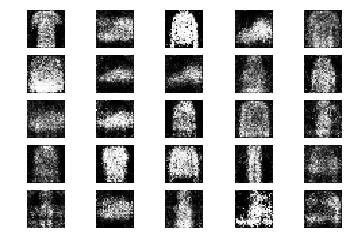

1001 [D loss: 0.628679, acc.: 69.00%] [G loss: 0.891413]
1002 [D loss: 0.597859, acc.: 73.00%] [G loss: 0.782468]
1003 [D loss: 0.666289, acc.: 58.00%] [G loss: 0.783489]
1004 [D loss: 0.623389, acc.: 64.00%] [G loss: 0.792735]
1005 [D loss: 0.606382, acc.: 67.00%] [G loss: 0.790764]
1006 [D loss: 0.683671, acc.: 51.00%] [G loss: 0.728796]
1007 [D loss: 0.683547, acc.: 48.00%] [G loss: 0.773766]
1008 [D loss: 0.644240, acc.: 60.00%] [G loss: 0.767575]
1009 [D loss: 0.650428, acc.: 57.00%] [G loss: 0.879611]
1010 [D loss: 0.681927, acc.: 54.00%] [G loss: 0.805483]
1011 [D loss: 0.667177, acc.: 61.00%] [G loss: 0.822885]
1012 [D loss: 0.618005, acc.: 65.00%] [G loss: 0.830412]
1013 [D loss: 0.626862, acc.: 62.00%] [G loss: 0.820270]
1014 [D loss: 0.600685, acc.: 68.00%] [G loss: 0.888324]
1015 [D loss: 0.618772, acc.: 63.00%] [G loss: 0.789059]
1016 [D loss: 0.661222, acc.: 60.00%] [G loss: 0.866750]
1017 [D loss: 0.657417, acc.: 57.00%] [G loss: 0.828945]
1018 [D loss: 0.645346, acc.: 7

1145 [D loss: 0.629901, acc.: 68.00%] [G loss: 0.861951]
1146 [D loss: 0.656846, acc.: 59.00%] [G loss: 0.820482]
1147 [D loss: 0.671746, acc.: 62.00%] [G loss: 0.816524]
1148 [D loss: 0.612302, acc.: 62.00%] [G loss: 0.830518]
1149 [D loss: 0.640779, acc.: 60.00%] [G loss: 0.842817]
1150 [D loss: 0.641897, acc.: 66.00%] [G loss: 0.801611]
1151 [D loss: 0.645672, acc.: 59.00%] [G loss: 0.842849]
1152 [D loss: 0.600122, acc.: 70.00%] [G loss: 0.834216]
1153 [D loss: 0.669856, acc.: 61.00%] [G loss: 0.797758]
1154 [D loss: 0.650622, acc.: 62.00%] [G loss: 0.818331]
1155 [D loss: 0.627666, acc.: 62.00%] [G loss: 0.760872]
1156 [D loss: 0.645181, acc.: 64.00%] [G loss: 0.845620]
1157 [D loss: 0.650483, acc.: 56.00%] [G loss: 0.845520]
1158 [D loss: 0.642076, acc.: 61.00%] [G loss: 0.821879]
1159 [D loss: 0.679232, acc.: 54.00%] [G loss: 0.820924]
1160 [D loss: 0.625351, acc.: 65.00%] [G loss: 0.853031]
1161 [D loss: 0.624928, acc.: 66.00%] [G loss: 0.847182]
1162 [D loss: 0.657525, acc.: 5

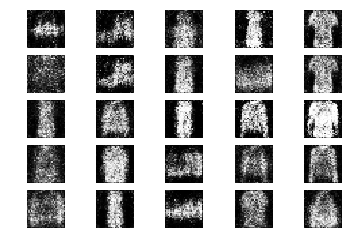

1201 [D loss: 0.616705, acc.: 66.00%] [G loss: 0.793678]
1202 [D loss: 0.630951, acc.: 63.00%] [G loss: 0.830441]
1203 [D loss: 0.630112, acc.: 59.00%] [G loss: 0.843652]
1204 [D loss: 0.608430, acc.: 70.00%] [G loss: 0.862621]
1205 [D loss: 0.680151, acc.: 53.00%] [G loss: 0.795503]
1206 [D loss: 0.604520, acc.: 69.00%] [G loss: 0.873652]
1207 [D loss: 0.652547, acc.: 58.00%] [G loss: 0.787372]
1208 [D loss: 0.655341, acc.: 54.00%] [G loss: 0.868476]
1209 [D loss: 0.649612, acc.: 63.00%] [G loss: 0.809800]
1210 [D loss: 0.620851, acc.: 67.00%] [G loss: 0.831981]
1211 [D loss: 0.589581, acc.: 76.00%] [G loss: 0.891782]
1212 [D loss: 0.679382, acc.: 59.00%] [G loss: 0.820349]
1213 [D loss: 0.616840, acc.: 65.00%] [G loss: 0.873805]
1214 [D loss: 0.625386, acc.: 68.00%] [G loss: 0.841633]
1215 [D loss: 0.645382, acc.: 60.00%] [G loss: 0.836885]
1216 [D loss: 0.613051, acc.: 63.00%] [G loss: 0.840633]
1217 [D loss: 0.646573, acc.: 66.00%] [G loss: 0.816180]
1218 [D loss: 0.599813, acc.: 7

1346 [D loss: 0.637016, acc.: 65.00%] [G loss: 0.843622]
1347 [D loss: 0.618798, acc.: 68.00%] [G loss: 0.885979]
1348 [D loss: 0.630744, acc.: 68.00%] [G loss: 0.828265]
1349 [D loss: 0.623075, acc.: 62.00%] [G loss: 0.830768]
1350 [D loss: 0.681276, acc.: 57.00%] [G loss: 0.862509]
1351 [D loss: 0.580983, acc.: 74.00%] [G loss: 0.971503]
1352 [D loss: 0.613287, acc.: 73.00%] [G loss: 0.923752]
1353 [D loss: 0.611385, acc.: 69.00%] [G loss: 0.935670]
1354 [D loss: 0.605942, acc.: 67.00%] [G loss: 0.814680]
1355 [D loss: 0.658700, acc.: 60.00%] [G loss: 0.795208]
1356 [D loss: 0.672316, acc.: 54.00%] [G loss: 0.913600]
1357 [D loss: 0.634693, acc.: 67.00%] [G loss: 0.887822]
1358 [D loss: 0.648333, acc.: 64.00%] [G loss: 0.846570]
1359 [D loss: 0.587580, acc.: 69.00%] [G loss: 0.840725]
1360 [D loss: 0.561701, acc.: 72.00%] [G loss: 0.912012]
1361 [D loss: 0.629715, acc.: 64.00%] [G loss: 0.846795]
1362 [D loss: 0.637391, acc.: 62.00%] [G loss: 0.891976]
1363 [D loss: 0.660899, acc.: 6

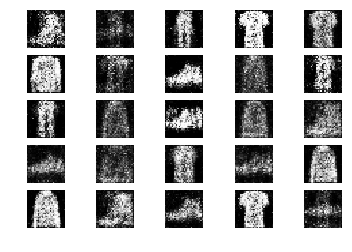

1401 [D loss: 0.659600, acc.: 65.00%] [G loss: 0.863431]
1402 [D loss: 0.604300, acc.: 72.00%] [G loss: 0.853762]
1403 [D loss: 0.585231, acc.: 75.00%] [G loss: 0.864735]
1404 [D loss: 0.640801, acc.: 69.00%] [G loss: 0.872693]
1405 [D loss: 0.639919, acc.: 61.00%] [G loss: 0.955746]
1406 [D loss: 0.663314, acc.: 59.00%] [G loss: 0.888221]
1407 [D loss: 0.601165, acc.: 75.00%] [G loss: 0.907760]
1408 [D loss: 0.661497, acc.: 56.00%] [G loss: 0.915998]
1409 [D loss: 0.633703, acc.: 64.00%] [G loss: 0.857853]
1410 [D loss: 0.587893, acc.: 73.00%] [G loss: 0.895307]
1411 [D loss: 0.646039, acc.: 59.00%] [G loss: 0.904272]
1412 [D loss: 0.636790, acc.: 62.00%] [G loss: 0.882685]
1413 [D loss: 0.645019, acc.: 59.00%] [G loss: 0.902738]
1414 [D loss: 0.618206, acc.: 59.00%] [G loss: 0.872845]
1415 [D loss: 0.580521, acc.: 75.00%] [G loss: 0.914133]
1416 [D loss: 0.667832, acc.: 51.00%] [G loss: 0.901519]
1417 [D loss: 0.649086, acc.: 66.00%] [G loss: 0.917030]
1418 [D loss: 0.619532, acc.: 6

1545 [D loss: 0.633344, acc.: 63.00%] [G loss: 0.919033]
1546 [D loss: 0.621339, acc.: 64.00%] [G loss: 0.880318]
1547 [D loss: 0.638251, acc.: 61.00%] [G loss: 0.895003]
1548 [D loss: 0.645236, acc.: 68.00%] [G loss: 0.844799]
1549 [D loss: 0.602070, acc.: 72.00%] [G loss: 0.883360]
1550 [D loss: 0.607273, acc.: 64.00%] [G loss: 0.877457]
1551 [D loss: 0.606968, acc.: 71.00%] [G loss: 0.882305]
1552 [D loss: 0.637647, acc.: 68.00%] [G loss: 0.885499]
1553 [D loss: 0.651917, acc.: 58.00%] [G loss: 0.803221]
1554 [D loss: 0.672072, acc.: 54.00%] [G loss: 0.823823]
1555 [D loss: 0.630666, acc.: 57.00%] [G loss: 0.858258]
1556 [D loss: 0.613823, acc.: 65.00%] [G loss: 0.823364]
1557 [D loss: 0.684690, acc.: 54.00%] [G loss: 0.893053]
1558 [D loss: 0.644717, acc.: 61.00%] [G loss: 0.901443]
1559 [D loss: 0.605857, acc.: 65.00%] [G loss: 0.930034]
1560 [D loss: 0.673176, acc.: 53.00%] [G loss: 0.956394]
1561 [D loss: 0.646070, acc.: 62.00%] [G loss: 0.870634]
1562 [D loss: 0.661757, acc.: 6

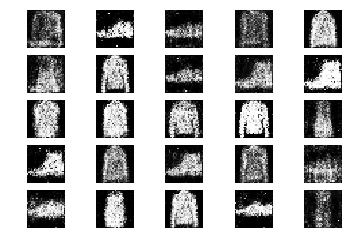

1601 [D loss: 0.587902, acc.: 66.00%] [G loss: 0.895218]
1602 [D loss: 0.660131, acc.: 58.00%] [G loss: 0.938424]
1603 [D loss: 0.647800, acc.: 59.00%] [G loss: 0.906763]
1604 [D loss: 0.698435, acc.: 52.00%] [G loss: 0.853985]
1605 [D loss: 0.653506, acc.: 58.00%] [G loss: 0.830478]
1606 [D loss: 0.604744, acc.: 63.00%] [G loss: 0.863456]
1607 [D loss: 0.651012, acc.: 62.00%] [G loss: 0.852843]
1608 [D loss: 0.627545, acc.: 62.00%] [G loss: 0.842714]
1609 [D loss: 0.646968, acc.: 61.00%] [G loss: 0.863845]
1610 [D loss: 0.608520, acc.: 65.00%] [G loss: 0.865957]
1611 [D loss: 0.667283, acc.: 58.00%] [G loss: 0.822106]
1612 [D loss: 0.681961, acc.: 60.00%] [G loss: 0.817532]
1613 [D loss: 0.617715, acc.: 70.00%] [G loss: 0.844998]
1614 [D loss: 0.643362, acc.: 65.00%] [G loss: 0.862805]
1615 [D loss: 0.614145, acc.: 64.00%] [G loss: 0.840505]
1616 [D loss: 0.576289, acc.: 69.00%] [G loss: 0.876747]
1617 [D loss: 0.656991, acc.: 64.00%] [G loss: 0.871991]
1618 [D loss: 0.623651, acc.: 6

1745 [D loss: 0.628061, acc.: 66.00%] [G loss: 0.919673]
1746 [D loss: 0.622671, acc.: 64.00%] [G loss: 0.860471]
1747 [D loss: 0.591457, acc.: 71.00%] [G loss: 0.893032]
1748 [D loss: 0.631269, acc.: 63.00%] [G loss: 0.863431]
1749 [D loss: 0.660407, acc.: 63.00%] [G loss: 0.899305]
1750 [D loss: 0.650911, acc.: 62.00%] [G loss: 0.936574]
1751 [D loss: 0.606942, acc.: 69.00%] [G loss: 0.873895]
1752 [D loss: 0.662248, acc.: 62.00%] [G loss: 0.806308]
1753 [D loss: 0.680405, acc.: 57.00%] [G loss: 0.881875]
1754 [D loss: 0.657782, acc.: 57.00%] [G loss: 0.874300]
1755 [D loss: 0.652605, acc.: 61.00%] [G loss: 0.886894]
1756 [D loss: 0.654748, acc.: 63.00%] [G loss: 0.844860]
1757 [D loss: 0.626466, acc.: 72.00%] [G loss: 0.931449]
1758 [D loss: 0.668319, acc.: 65.00%] [G loss: 0.861170]
1759 [D loss: 0.660724, acc.: 63.00%] [G loss: 0.817139]
1760 [D loss: 0.599693, acc.: 69.00%] [G loss: 0.842215]
1761 [D loss: 0.617560, acc.: 65.00%] [G loss: 0.881263]
1762 [D loss: 0.595112, acc.: 6

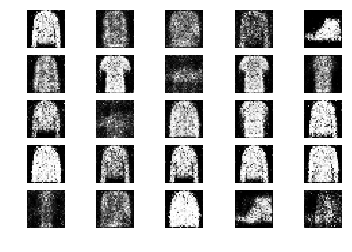

1801 [D loss: 0.627159, acc.: 70.00%] [G loss: 0.898541]
1802 [D loss: 0.632134, acc.: 62.00%] [G loss: 0.877175]
1803 [D loss: 0.632974, acc.: 67.00%] [G loss: 0.864696]
1804 [D loss: 0.604399, acc.: 65.00%] [G loss: 0.871425]
1805 [D loss: 0.602277, acc.: 67.00%] [G loss: 0.840380]
1806 [D loss: 0.630275, acc.: 69.00%] [G loss: 0.849307]
1807 [D loss: 0.680478, acc.: 60.00%] [G loss: 0.945455]
1808 [D loss: 0.655648, acc.: 63.00%] [G loss: 0.938351]
1809 [D loss: 0.643593, acc.: 64.00%] [G loss: 0.877439]
1810 [D loss: 0.649592, acc.: 59.00%] [G loss: 0.891861]
1811 [D loss: 0.626798, acc.: 66.00%] [G loss: 0.869772]
1812 [D loss: 0.622780, acc.: 62.00%] [G loss: 0.865865]
1813 [D loss: 0.648556, acc.: 62.00%] [G loss: 0.924933]
1814 [D loss: 0.638276, acc.: 65.00%] [G loss: 0.943993]
1815 [D loss: 0.606637, acc.: 70.00%] [G loss: 0.933302]
1816 [D loss: 0.605239, acc.: 66.00%] [G loss: 0.848640]
1817 [D loss: 0.661956, acc.: 57.00%] [G loss: 0.923120]
1818 [D loss: 0.645273, acc.: 5

1945 [D loss: 0.626655, acc.: 74.00%] [G loss: 0.833258]
1946 [D loss: 0.675464, acc.: 63.00%] [G loss: 0.836413]
1947 [D loss: 0.671197, acc.: 56.00%] [G loss: 0.881302]
1948 [D loss: 0.595567, acc.: 67.00%] [G loss: 0.792675]
1949 [D loss: 0.637905, acc.: 60.00%] [G loss: 0.872380]
1950 [D loss: 0.638988, acc.: 59.00%] [G loss: 0.879172]
1951 [D loss: 0.614502, acc.: 66.00%] [G loss: 0.876620]
1952 [D loss: 0.694979, acc.: 54.00%] [G loss: 0.856044]
1953 [D loss: 0.680248, acc.: 57.00%] [G loss: 0.864519]
1954 [D loss: 0.650208, acc.: 57.00%] [G loss: 0.835022]
1955 [D loss: 0.678451, acc.: 57.00%] [G loss: 0.828018]
1956 [D loss: 0.630683, acc.: 60.00%] [G loss: 0.849399]
1957 [D loss: 0.637720, acc.: 67.00%] [G loss: 0.866925]
1958 [D loss: 0.678393, acc.: 57.00%] [G loss: 0.884236]
1959 [D loss: 0.620442, acc.: 66.00%] [G loss: 0.807631]
1960 [D loss: 0.630456, acc.: 69.00%] [G loss: 0.839223]
1961 [D loss: 0.694159, acc.: 50.00%] [G loss: 0.867365]
1962 [D loss: 0.665762, acc.: 5

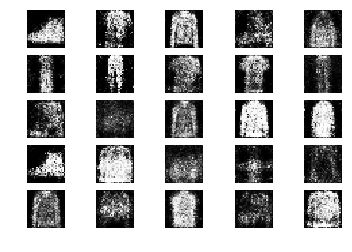

2001 [D loss: 0.607808, acc.: 69.00%] [G loss: 0.845233]
2002 [D loss: 0.721113, acc.: 50.00%] [G loss: 0.837863]
2003 [D loss: 0.605333, acc.: 69.00%] [G loss: 0.915474]
2004 [D loss: 0.648548, acc.: 61.00%] [G loss: 0.870018]
2005 [D loss: 0.636506, acc.: 66.00%] [G loss: 0.924041]
2006 [D loss: 0.667053, acc.: 59.00%] [G loss: 0.826867]
2007 [D loss: 0.661654, acc.: 58.00%] [G loss: 0.912024]
2008 [D loss: 0.588317, acc.: 74.00%] [G loss: 0.877927]
2009 [D loss: 0.669384, acc.: 55.00%] [G loss: 0.839308]
2010 [D loss: 0.645359, acc.: 64.00%] [G loss: 0.880028]
2011 [D loss: 0.646252, acc.: 60.00%] [G loss: 0.889156]
2012 [D loss: 0.631677, acc.: 57.00%] [G loss: 0.866881]
2013 [D loss: 0.600296, acc.: 72.00%] [G loss: 0.886108]
2014 [D loss: 0.621744, acc.: 67.00%] [G loss: 0.860977]
2015 [D loss: 0.705844, acc.: 53.00%] [G loss: 0.864944]
2016 [D loss: 0.610133, acc.: 71.00%] [G loss: 0.892297]
2017 [D loss: 0.677787, acc.: 55.00%] [G loss: 0.869753]
2018 [D loss: 0.678894, acc.: 5

2145 [D loss: 0.602857, acc.: 70.00%] [G loss: 0.770913]
2146 [D loss: 0.653551, acc.: 63.00%] [G loss: 0.878597]
2147 [D loss: 0.672489, acc.: 59.00%] [G loss: 0.854704]
2148 [D loss: 0.666608, acc.: 52.00%] [G loss: 0.906332]
2149 [D loss: 0.683333, acc.: 57.00%] [G loss: 0.839161]
2150 [D loss: 0.653978, acc.: 67.00%] [G loss: 0.829203]
2151 [D loss: 0.671267, acc.: 58.00%] [G loss: 0.843340]
2152 [D loss: 0.681826, acc.: 57.00%] [G loss: 0.867732]
2153 [D loss: 0.645953, acc.: 62.00%] [G loss: 0.868180]
2154 [D loss: 0.614534, acc.: 63.00%] [G loss: 0.894293]
2155 [D loss: 0.692390, acc.: 59.00%] [G loss: 0.985243]
2156 [D loss: 0.629188, acc.: 65.00%] [G loss: 0.908369]
2157 [D loss: 0.593809, acc.: 66.00%] [G loss: 0.941711]
2158 [D loss: 0.592685, acc.: 73.00%] [G loss: 0.900354]
2159 [D loss: 0.671281, acc.: 63.00%] [G loss: 0.915553]
2160 [D loss: 0.570821, acc.: 72.00%] [G loss: 0.937415]
2161 [D loss: 0.609637, acc.: 63.00%] [G loss: 0.941210]
2162 [D loss: 0.662996, acc.: 5

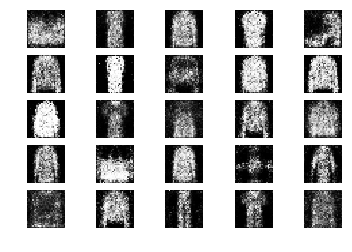

2201 [D loss: 0.642673, acc.: 60.00%] [G loss: 0.861653]
2202 [D loss: 0.690752, acc.: 49.00%] [G loss: 0.899360]
2203 [D loss: 0.612758, acc.: 69.00%] [G loss: 0.890763]
2204 [D loss: 0.632511, acc.: 64.00%] [G loss: 0.951297]
2205 [D loss: 0.622043, acc.: 66.00%] [G loss: 0.872984]
2206 [D loss: 0.639728, acc.: 64.00%] [G loss: 0.842055]
2207 [D loss: 0.572181, acc.: 70.00%] [G loss: 0.917980]
2208 [D loss: 0.684973, acc.: 59.00%] [G loss: 0.841138]
2209 [D loss: 0.666108, acc.: 58.00%] [G loss: 0.908835]
2210 [D loss: 0.646079, acc.: 68.00%] [G loss: 0.854023]
2211 [D loss: 0.659244, acc.: 59.00%] [G loss: 0.791089]
2212 [D loss: 0.690862, acc.: 53.00%] [G loss: 0.892518]
2213 [D loss: 0.652028, acc.: 62.00%] [G loss: 0.852097]
2214 [D loss: 0.589011, acc.: 73.00%] [G loss: 0.887762]
2215 [D loss: 0.651773, acc.: 58.00%] [G loss: 0.874324]
2216 [D loss: 0.651226, acc.: 59.00%] [G loss: 0.877148]
2217 [D loss: 0.616507, acc.: 66.00%] [G loss: 0.872621]
2218 [D loss: 0.648808, acc.: 5

2345 [D loss: 0.676793, acc.: 54.00%] [G loss: 0.841387]
2346 [D loss: 0.626642, acc.: 66.00%] [G loss: 0.871164]
2347 [D loss: 0.686420, acc.: 53.00%] [G loss: 0.865851]
2348 [D loss: 0.593406, acc.: 66.00%] [G loss: 0.880979]
2349 [D loss: 0.628546, acc.: 64.00%] [G loss: 0.919758]
2350 [D loss: 0.617659, acc.: 67.00%] [G loss: 0.897044]
2351 [D loss: 0.635309, acc.: 60.00%] [G loss: 0.898995]
2352 [D loss: 0.599987, acc.: 70.00%] [G loss: 0.890081]
2353 [D loss: 0.654990, acc.: 64.00%] [G loss: 0.819929]
2354 [D loss: 0.621383, acc.: 63.00%] [G loss: 0.940430]
2355 [D loss: 0.634837, acc.: 60.00%] [G loss: 0.917431]
2356 [D loss: 0.615923, acc.: 60.00%] [G loss: 0.833490]
2357 [D loss: 0.640813, acc.: 65.00%] [G loss: 0.897676]
2358 [D loss: 0.661680, acc.: 64.00%] [G loss: 0.857095]
2359 [D loss: 0.638109, acc.: 60.00%] [G loss: 0.871053]
2360 [D loss: 0.689456, acc.: 54.00%] [G loss: 0.837518]
2361 [D loss: 0.664421, acc.: 60.00%] [G loss: 0.861484]
2362 [D loss: 0.627625, acc.: 6

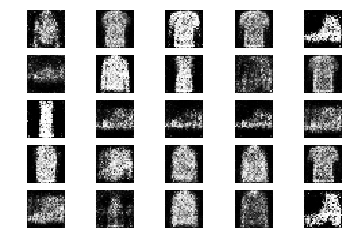

2401 [D loss: 0.684347, acc.: 53.00%] [G loss: 0.884200]
2402 [D loss: 0.622011, acc.: 61.00%] [G loss: 0.873966]
2403 [D loss: 0.635382, acc.: 59.00%] [G loss: 0.908542]
2404 [D loss: 0.660424, acc.: 61.00%] [G loss: 0.845236]
2405 [D loss: 0.662297, acc.: 58.00%] [G loss: 0.858252]
2406 [D loss: 0.597809, acc.: 63.00%] [G loss: 0.885395]
2407 [D loss: 0.647137, acc.: 60.00%] [G loss: 0.853411]
2408 [D loss: 0.615163, acc.: 66.00%] [G loss: 0.892613]
2409 [D loss: 0.634356, acc.: 64.00%] [G loss: 0.897225]
2410 [D loss: 0.755367, acc.: 53.00%] [G loss: 0.942646]
2411 [D loss: 0.602736, acc.: 64.00%] [G loss: 0.878911]
2412 [D loss: 0.607613, acc.: 63.00%] [G loss: 0.846751]
2413 [D loss: 0.629232, acc.: 66.00%] [G loss: 0.854441]
2414 [D loss: 0.632563, acc.: 64.00%] [G loss: 0.866692]
2415 [D loss: 0.641888, acc.: 60.00%] [G loss: 0.905778]
2416 [D loss: 0.684085, acc.: 58.00%] [G loss: 0.960170]
2417 [D loss: 0.634931, acc.: 67.00%] [G loss: 0.938483]
2418 [D loss: 0.630808, acc.: 6

2545 [D loss: 0.648122, acc.: 62.00%] [G loss: 0.866402]
2546 [D loss: 0.627683, acc.: 65.00%] [G loss: 0.835887]
2547 [D loss: 0.604237, acc.: 62.00%] [G loss: 0.868388]
2548 [D loss: 0.597880, acc.: 67.00%] [G loss: 0.923010]
2549 [D loss: 0.705447, acc.: 55.00%] [G loss: 0.897809]
2550 [D loss: 0.670228, acc.: 60.00%] [G loss: 0.872470]
2551 [D loss: 0.673149, acc.: 55.00%] [G loss: 0.859837]
2552 [D loss: 0.647939, acc.: 68.00%] [G loss: 0.874907]
2553 [D loss: 0.672861, acc.: 59.00%] [G loss: 0.905865]
2554 [D loss: 0.657441, acc.: 58.00%] [G loss: 0.924959]
2555 [D loss: 0.650286, acc.: 60.00%] [G loss: 0.870857]
2556 [D loss: 0.632446, acc.: 67.00%] [G loss: 0.849732]
2557 [D loss: 0.605400, acc.: 65.00%] [G loss: 0.826481]
2558 [D loss: 0.692336, acc.: 56.00%] [G loss: 0.797875]
2559 [D loss: 0.652090, acc.: 62.00%] [G loss: 0.825073]
2560 [D loss: 0.640284, acc.: 63.00%] [G loss: 0.886926]
2561 [D loss: 0.639865, acc.: 60.00%] [G loss: 0.924534]
2562 [D loss: 0.664798, acc.: 5

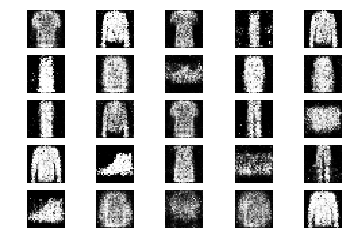

2601 [D loss: 0.634339, acc.: 63.00%] [G loss: 0.985143]
2602 [D loss: 0.649347, acc.: 62.00%] [G loss: 0.895599]
2603 [D loss: 0.687657, acc.: 60.00%] [G loss: 0.901604]
2604 [D loss: 0.619027, acc.: 65.00%] [G loss: 0.891837]
2605 [D loss: 0.666316, acc.: 52.00%] [G loss: 0.888214]
2606 [D loss: 0.653525, acc.: 60.00%] [G loss: 0.903588]
2607 [D loss: 0.668327, acc.: 52.00%] [G loss: 0.907800]
2608 [D loss: 0.653654, acc.: 65.00%] [G loss: 0.852367]
2609 [D loss: 0.653066, acc.: 59.00%] [G loss: 0.894990]
2610 [D loss: 0.690166, acc.: 61.00%] [G loss: 0.844819]
2611 [D loss: 0.624841, acc.: 66.00%] [G loss: 0.857329]
2612 [D loss: 0.615561, acc.: 61.00%] [G loss: 0.898047]
2613 [D loss: 0.650069, acc.: 63.00%] [G loss: 0.862586]
2614 [D loss: 0.665461, acc.: 58.00%] [G loss: 0.965485]
2615 [D loss: 0.661462, acc.: 62.00%] [G loss: 0.923101]
2616 [D loss: 0.613429, acc.: 64.00%] [G loss: 0.890437]
2617 [D loss: 0.606349, acc.: 69.00%] [G loss: 0.890442]
2618 [D loss: 0.641033, acc.: 6

2745 [D loss: 0.638482, acc.: 64.00%] [G loss: 0.909030]
2746 [D loss: 0.676196, acc.: 59.00%] [G loss: 0.920823]
2747 [D loss: 0.644979, acc.: 64.00%] [G loss: 0.927718]
2748 [D loss: 0.625592, acc.: 63.00%] [G loss: 0.999408]
2749 [D loss: 0.659755, acc.: 62.00%] [G loss: 0.887610]
2750 [D loss: 0.631518, acc.: 65.00%] [G loss: 0.823607]
2751 [D loss: 0.669590, acc.: 57.00%] [G loss: 0.836890]
2752 [D loss: 0.658185, acc.: 64.00%] [G loss: 0.879837]
2753 [D loss: 0.647144, acc.: 65.00%] [G loss: 0.863275]
2754 [D loss: 0.645640, acc.: 64.00%] [G loss: 0.873729]
2755 [D loss: 0.645419, acc.: 64.00%] [G loss: 0.923714]
2756 [D loss: 0.636340, acc.: 62.00%] [G loss: 0.959557]
2757 [D loss: 0.656291, acc.: 57.00%] [G loss: 0.858867]
2758 [D loss: 0.680326, acc.: 55.00%] [G loss: 0.836970]
2759 [D loss: 0.629157, acc.: 72.00%] [G loss: 0.835189]
2760 [D loss: 0.631767, acc.: 67.00%] [G loss: 0.874654]
2761 [D loss: 0.645978, acc.: 64.00%] [G loss: 0.911269]
2762 [D loss: 0.676334, acc.: 5

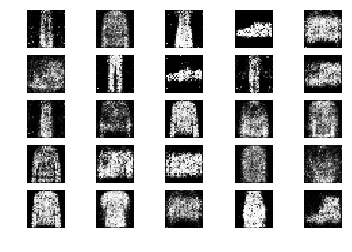

2801 [D loss: 0.629773, acc.: 60.00%] [G loss: 0.870087]
2802 [D loss: 0.632222, acc.: 65.00%] [G loss: 0.868721]
2803 [D loss: 0.637811, acc.: 66.00%] [G loss: 0.864226]
2804 [D loss: 0.604263, acc.: 72.00%] [G loss: 0.864659]
2805 [D loss: 0.676254, acc.: 65.00%] [G loss: 0.851146]
2806 [D loss: 0.673552, acc.: 58.00%] [G loss: 0.881011]
2807 [D loss: 0.640180, acc.: 63.00%] [G loss: 0.865521]
2808 [D loss: 0.685515, acc.: 55.00%] [G loss: 0.903298]
2809 [D loss: 0.647551, acc.: 65.00%] [G loss: 0.899658]
2810 [D loss: 0.628266, acc.: 65.00%] [G loss: 0.925143]
2811 [D loss: 0.608811, acc.: 67.00%] [G loss: 0.854413]
2812 [D loss: 0.638452, acc.: 63.00%] [G loss: 0.895037]
2813 [D loss: 0.656062, acc.: 56.00%] [G loss: 0.917797]
2814 [D loss: 0.638065, acc.: 63.00%] [G loss: 0.906908]
2815 [D loss: 0.651653, acc.: 64.00%] [G loss: 0.929813]
2816 [D loss: 0.651735, acc.: 62.00%] [G loss: 0.902791]
2817 [D loss: 0.662820, acc.: 61.00%] [G loss: 0.980546]
2818 [D loss: 0.644159, acc.: 5

2945 [D loss: 0.645670, acc.: 63.00%] [G loss: 0.869844]
2946 [D loss: 0.658150, acc.: 62.00%] [G loss: 0.918507]
2947 [D loss: 0.601784, acc.: 70.00%] [G loss: 0.876468]
2948 [D loss: 0.687364, acc.: 58.00%] [G loss: 0.910826]
2949 [D loss: 0.672570, acc.: 57.00%] [G loss: 0.895623]
2950 [D loss: 0.587762, acc.: 73.00%] [G loss: 0.945934]
2951 [D loss: 0.648223, acc.: 63.00%] [G loss: 0.856687]
2952 [D loss: 0.611683, acc.: 67.00%] [G loss: 0.906005]
2953 [D loss: 0.658801, acc.: 59.00%] [G loss: 0.872504]
2954 [D loss: 0.636974, acc.: 64.00%] [G loss: 0.815272]
2955 [D loss: 0.623639, acc.: 65.00%] [G loss: 0.919535]
2956 [D loss: 0.624981, acc.: 65.00%] [G loss: 0.860829]
2957 [D loss: 0.630950, acc.: 59.00%] [G loss: 0.922742]
2958 [D loss: 0.693447, acc.: 52.00%] [G loss: 0.872742]
2959 [D loss: 0.682619, acc.: 59.00%] [G loss: 0.907869]
2960 [D loss: 0.636653, acc.: 67.00%] [G loss: 0.884642]
2961 [D loss: 0.670766, acc.: 61.00%] [G loss: 0.872979]
2962 [D loss: 0.641257, acc.: 6

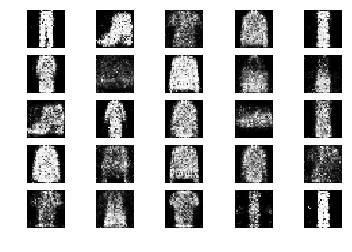

3001 [D loss: 0.632648, acc.: 58.00%] [G loss: 0.857840]
3002 [D loss: 0.627461, acc.: 65.00%] [G loss: 0.868981]
3003 [D loss: 0.615596, acc.: 68.00%] [G loss: 0.911922]
3004 [D loss: 0.626600, acc.: 63.00%] [G loss: 0.906630]
3005 [D loss: 0.650221, acc.: 63.00%] [G loss: 0.888695]
3006 [D loss: 0.631195, acc.: 63.00%] [G loss: 0.877044]
3007 [D loss: 0.573348, acc.: 70.00%] [G loss: 0.889525]
3008 [D loss: 0.637466, acc.: 64.00%] [G loss: 0.888443]
3009 [D loss: 0.620255, acc.: 65.00%] [G loss: 0.943633]
3010 [D loss: 0.648050, acc.: 65.00%] [G loss: 0.941880]
3011 [D loss: 0.665147, acc.: 60.00%] [G loss: 0.944301]
3012 [D loss: 0.682815, acc.: 62.00%] [G loss: 1.019118]
3013 [D loss: 0.681765, acc.: 56.00%] [G loss: 0.986955]
3014 [D loss: 0.688665, acc.: 54.00%] [G loss: 0.893908]
3015 [D loss: 0.623212, acc.: 63.00%] [G loss: 0.882267]
3016 [D loss: 0.632691, acc.: 64.00%] [G loss: 0.919175]
3017 [D loss: 0.644454, acc.: 62.00%] [G loss: 0.854614]
3018 [D loss: 0.633410, acc.: 5

3146 [D loss: 0.652390, acc.: 56.00%] [G loss: 0.942183]
3147 [D loss: 0.650830, acc.: 63.00%] [G loss: 0.851797]
3148 [D loss: 0.671649, acc.: 54.00%] [G loss: 0.876389]
3149 [D loss: 0.648378, acc.: 58.00%] [G loss: 0.839102]
3150 [D loss: 0.626788, acc.: 71.00%] [G loss: 0.869780]
3151 [D loss: 0.643733, acc.: 61.00%] [G loss: 0.844187]
3152 [D loss: 0.676936, acc.: 61.00%] [G loss: 0.844939]
3153 [D loss: 0.660733, acc.: 65.00%] [G loss: 0.874173]
3154 [D loss: 0.643910, acc.: 64.00%] [G loss: 0.892350]
3155 [D loss: 0.586691, acc.: 73.00%] [G loss: 0.887650]
3156 [D loss: 0.659670, acc.: 63.00%] [G loss: 0.837864]
3157 [D loss: 0.679360, acc.: 52.00%] [G loss: 0.803986]
3158 [D loss: 0.646882, acc.: 55.00%] [G loss: 0.872914]
3159 [D loss: 0.640918, acc.: 62.00%] [G loss: 0.902994]
3160 [D loss: 0.633049, acc.: 64.00%] [G loss: 0.831137]
3161 [D loss: 0.638605, acc.: 63.00%] [G loss: 0.826177]
3162 [D loss: 0.694157, acc.: 59.00%] [G loss: 0.906333]
3163 [D loss: 0.647905, acc.: 6

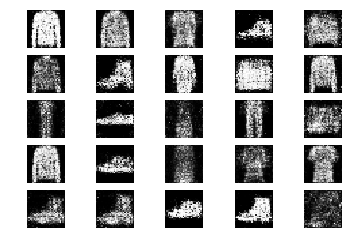

3201 [D loss: 0.653886, acc.: 63.00%] [G loss: 0.899966]
3202 [D loss: 0.656668, acc.: 67.00%] [G loss: 0.873395]
3203 [D loss: 0.631780, acc.: 63.00%] [G loss: 0.870629]
3204 [D loss: 0.628379, acc.: 70.00%] [G loss: 0.879339]
3205 [D loss: 0.662453, acc.: 60.00%] [G loss: 0.872800]
3206 [D loss: 0.661330, acc.: 57.00%] [G loss: 0.861298]
3207 [D loss: 0.646952, acc.: 62.00%] [G loss: 0.842483]
3208 [D loss: 0.697320, acc.: 49.00%] [G loss: 0.834126]
3209 [D loss: 0.689368, acc.: 61.00%] [G loss: 0.877373]
3210 [D loss: 0.660571, acc.: 62.00%] [G loss: 0.957920]
3211 [D loss: 0.674421, acc.: 62.00%] [G loss: 0.849421]
3212 [D loss: 0.643946, acc.: 68.00%] [G loss: 0.836941]
3213 [D loss: 0.642263, acc.: 69.00%] [G loss: 0.846134]
3214 [D loss: 0.667416, acc.: 60.00%] [G loss: 0.891464]
3215 [D loss: 0.601341, acc.: 69.00%] [G loss: 0.814508]
3216 [D loss: 0.675125, acc.: 58.00%] [G loss: 0.827779]
3217 [D loss: 0.641077, acc.: 64.00%] [G loss: 0.867813]
3218 [D loss: 0.692697, acc.: 5

3346 [D loss: 0.610715, acc.: 68.00%] [G loss: 0.881106]
3347 [D loss: 0.608629, acc.: 69.00%] [G loss: 0.848900]
3348 [D loss: 0.702441, acc.: 53.00%] [G loss: 0.899963]
3349 [D loss: 0.580194, acc.: 67.00%] [G loss: 0.845605]
3350 [D loss: 0.623574, acc.: 65.00%] [G loss: 0.854870]
3351 [D loss: 0.646549, acc.: 62.00%] [G loss: 0.943168]
3352 [D loss: 0.610452, acc.: 67.00%] [G loss: 0.924908]
3353 [D loss: 0.622609, acc.: 66.00%] [G loss: 0.889134]
3354 [D loss: 0.681111, acc.: 56.00%] [G loss: 0.996259]
3355 [D loss: 0.625190, acc.: 69.00%] [G loss: 0.916655]
3356 [D loss: 0.642863, acc.: 57.00%] [G loss: 0.910559]
3357 [D loss: 0.620559, acc.: 66.00%] [G loss: 0.967556]
3358 [D loss: 0.649420, acc.: 61.00%] [G loss: 0.888677]
3359 [D loss: 0.661907, acc.: 64.00%] [G loss: 0.905232]
3360 [D loss: 0.621415, acc.: 59.00%] [G loss: 0.898197]
3361 [D loss: 0.669975, acc.: 50.00%] [G loss: 0.917517]
3362 [D loss: 0.614380, acc.: 69.00%] [G loss: 0.916492]
3363 [D loss: 0.655606, acc.: 5

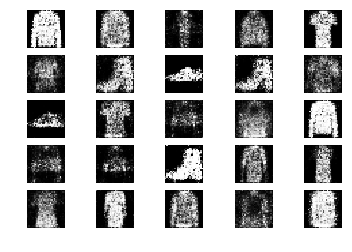

3401 [D loss: 0.607361, acc.: 71.00%] [G loss: 0.938568]
3402 [D loss: 0.691416, acc.: 52.00%] [G loss: 0.814570]
3403 [D loss: 0.688638, acc.: 53.00%] [G loss: 0.859271]
3404 [D loss: 0.616332, acc.: 70.00%] [G loss: 0.809572]
3405 [D loss: 0.665573, acc.: 50.00%] [G loss: 0.882517]
3406 [D loss: 0.697471, acc.: 55.00%] [G loss: 0.841284]
3407 [D loss: 0.619530, acc.: 69.00%] [G loss: 0.894784]
3408 [D loss: 0.636415, acc.: 58.00%] [G loss: 0.941025]
3409 [D loss: 0.671002, acc.: 54.00%] [G loss: 0.885187]
3410 [D loss: 0.625951, acc.: 70.00%] [G loss: 0.875874]
3411 [D loss: 0.626828, acc.: 68.00%] [G loss: 0.901932]
3412 [D loss: 0.647094, acc.: 60.00%] [G loss: 0.868069]
3413 [D loss: 0.661098, acc.: 57.00%] [G loss: 0.870170]
3414 [D loss: 0.652228, acc.: 59.00%] [G loss: 0.901773]
3415 [D loss: 0.644348, acc.: 64.00%] [G loss: 0.906417]
3416 [D loss: 0.648669, acc.: 61.00%] [G loss: 0.894607]
3417 [D loss: 0.674597, acc.: 54.00%] [G loss: 0.900926]
3418 [D loss: 0.664543, acc.: 6

3546 [D loss: 0.676401, acc.: 52.00%] [G loss: 0.884695]
3547 [D loss: 0.661479, acc.: 56.00%] [G loss: 0.787792]
3548 [D loss: 0.697816, acc.: 53.00%] [G loss: 0.872011]
3549 [D loss: 0.656738, acc.: 62.00%] [G loss: 0.882326]
3550 [D loss: 0.642073, acc.: 60.00%] [G loss: 0.851796]
3551 [D loss: 0.608747, acc.: 68.00%] [G loss: 0.809329]
3552 [D loss: 0.671563, acc.: 59.00%] [G loss: 0.815617]
3553 [D loss: 0.651829, acc.: 54.00%] [G loss: 0.854709]
3554 [D loss: 0.699382, acc.: 53.00%] [G loss: 0.906218]
3555 [D loss: 0.645545, acc.: 61.00%] [G loss: 0.880621]
3556 [D loss: 0.657508, acc.: 65.00%] [G loss: 0.854247]
3557 [D loss: 0.637988, acc.: 59.00%] [G loss: 0.909175]
3558 [D loss: 0.658380, acc.: 60.00%] [G loss: 0.851594]
3559 [D loss: 0.659109, acc.: 56.00%] [G loss: 0.851223]
3560 [D loss: 0.624693, acc.: 64.00%] [G loss: 0.852950]
3561 [D loss: 0.680829, acc.: 58.00%] [G loss: 0.840783]
3562 [D loss: 0.630626, acc.: 61.00%] [G loss: 0.798194]
3563 [D loss: 0.687303, acc.: 5

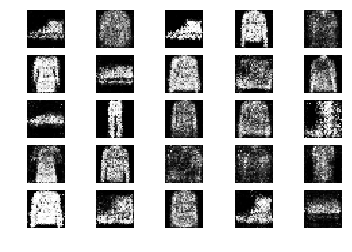

3601 [D loss: 0.723955, acc.: 50.00%] [G loss: 0.844735]
3602 [D loss: 0.613686, acc.: 65.00%] [G loss: 0.853892]
3603 [D loss: 0.649707, acc.: 61.00%] [G loss: 0.848979]
3604 [D loss: 0.634027, acc.: 65.00%] [G loss: 0.910349]
3605 [D loss: 0.639580, acc.: 69.00%] [G loss: 0.891118]
3606 [D loss: 0.638294, acc.: 65.00%] [G loss: 0.904279]
3607 [D loss: 0.660585, acc.: 58.00%] [G loss: 0.852028]
3608 [D loss: 0.628280, acc.: 67.00%] [G loss: 0.832450]
3609 [D loss: 0.664724, acc.: 55.00%] [G loss: 0.821967]
3610 [D loss: 0.661504, acc.: 62.00%] [G loss: 0.873527]
3611 [D loss: 0.625885, acc.: 70.00%] [G loss: 0.911726]
3612 [D loss: 0.654702, acc.: 61.00%] [G loss: 0.863483]
3613 [D loss: 0.704056, acc.: 61.00%] [G loss: 0.906566]
3614 [D loss: 0.645485, acc.: 63.00%] [G loss: 1.006790]
3615 [D loss: 0.652900, acc.: 59.00%] [G loss: 0.963864]
3616 [D loss: 0.702696, acc.: 52.00%] [G loss: 0.876601]
3617 [D loss: 0.670287, acc.: 60.00%] [G loss: 0.894760]
3618 [D loss: 0.645249, acc.: 6

3745 [D loss: 0.713930, acc.: 51.00%] [G loss: 0.852601]
3746 [D loss: 0.684413, acc.: 53.00%] [G loss: 0.866553]
3747 [D loss: 0.665339, acc.: 60.00%] [G loss: 0.914248]
3748 [D loss: 0.703496, acc.: 51.00%] [G loss: 0.862111]
3749 [D loss: 0.652962, acc.: 62.00%] [G loss: 0.868510]
3750 [D loss: 0.654336, acc.: 64.00%] [G loss: 0.838869]
3751 [D loss: 0.639052, acc.: 60.00%] [G loss: 0.912079]
3752 [D loss: 0.710220, acc.: 60.00%] [G loss: 0.864565]
3753 [D loss: 0.668067, acc.: 60.00%] [G loss: 0.914555]
3754 [D loss: 0.687066, acc.: 51.00%] [G loss: 0.888016]
3755 [D loss: 0.659842, acc.: 65.00%] [G loss: 0.879165]
3756 [D loss: 0.630017, acc.: 60.00%] [G loss: 0.917905]
3757 [D loss: 0.642664, acc.: 66.00%] [G loss: 0.847970]
3758 [D loss: 0.675712, acc.: 59.00%] [G loss: 0.866846]
3759 [D loss: 0.704208, acc.: 61.00%] [G loss: 0.870994]
3760 [D loss: 0.640760, acc.: 62.00%] [G loss: 0.905070]
3761 [D loss: 0.646542, acc.: 60.00%] [G loss: 0.829405]
3762 [D loss: 0.672197, acc.: 6

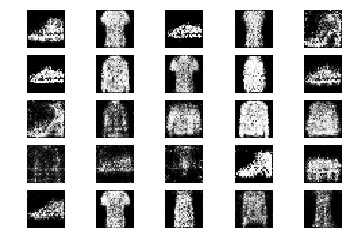

3801 [D loss: 0.648006, acc.: 59.00%] [G loss: 0.953889]
3802 [D loss: 0.642635, acc.: 63.00%] [G loss: 0.929868]
3803 [D loss: 0.679927, acc.: 55.00%] [G loss: 0.885706]
3804 [D loss: 0.658667, acc.: 59.00%] [G loss: 0.863152]
3805 [D loss: 0.660266, acc.: 60.00%] [G loss: 0.880475]
3806 [D loss: 0.643276, acc.: 64.00%] [G loss: 0.899559]
3807 [D loss: 0.650205, acc.: 65.00%] [G loss: 0.947216]
3808 [D loss: 0.606962, acc.: 69.00%] [G loss: 0.963431]
3809 [D loss: 0.654682, acc.: 59.00%] [G loss: 0.951545]
3810 [D loss: 0.665597, acc.: 61.00%] [G loss: 0.865473]
3811 [D loss: 0.672539, acc.: 58.00%] [G loss: 0.891227]
3812 [D loss: 0.672297, acc.: 52.00%] [G loss: 0.903507]
3813 [D loss: 0.649387, acc.: 62.00%] [G loss: 0.910426]
3814 [D loss: 0.682268, acc.: 58.00%] [G loss: 0.861997]
3815 [D loss: 0.661059, acc.: 65.00%] [G loss: 0.843097]
3816 [D loss: 0.629811, acc.: 68.00%] [G loss: 0.889411]
3817 [D loss: 0.623134, acc.: 65.00%] [G loss: 0.891345]
3818 [D loss: 0.639822, acc.: 6

3945 [D loss: 0.692420, acc.: 51.00%] [G loss: 0.784073]
3946 [D loss: 0.706396, acc.: 60.00%] [G loss: 0.868364]
3947 [D loss: 0.656046, acc.: 58.00%] [G loss: 0.868413]
3948 [D loss: 0.648931, acc.: 62.00%] [G loss: 0.878267]
3949 [D loss: 0.637262, acc.: 71.00%] [G loss: 0.852648]
3950 [D loss: 0.743134, acc.: 47.00%] [G loss: 0.910013]
3951 [D loss: 0.698234, acc.: 53.00%] [G loss: 0.899329]
3952 [D loss: 0.686320, acc.: 61.00%] [G loss: 0.879863]
3953 [D loss: 0.679215, acc.: 59.00%] [G loss: 0.901473]
3954 [D loss: 0.674075, acc.: 54.00%] [G loss: 0.853953]
3955 [D loss: 0.684420, acc.: 51.00%] [G loss: 0.864610]
3956 [D loss: 0.640308, acc.: 66.00%] [G loss: 0.855167]
3957 [D loss: 0.672752, acc.: 54.00%] [G loss: 0.845383]
3958 [D loss: 0.669712, acc.: 60.00%] [G loss: 0.871599]
3959 [D loss: 0.627266, acc.: 67.00%] [G loss: 0.830823]
3960 [D loss: 0.625752, acc.: 65.00%] [G loss: 0.855623]
3961 [D loss: 0.658151, acc.: 58.00%] [G loss: 0.885007]
3962 [D loss: 0.671364, acc.: 6

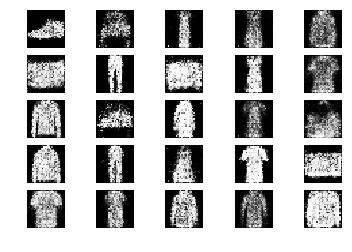

4001 [D loss: 0.677710, acc.: 55.00%] [G loss: 0.847324]
4002 [D loss: 0.695045, acc.: 60.00%] [G loss: 0.778967]
4003 [D loss: 0.657137, acc.: 60.00%] [G loss: 0.881654]
4004 [D loss: 0.659539, acc.: 60.00%] [G loss: 0.817417]
4005 [D loss: 0.655775, acc.: 57.00%] [G loss: 0.856251]
4006 [D loss: 0.674460, acc.: 57.00%] [G loss: 0.877552]
4007 [D loss: 0.640485, acc.: 66.00%] [G loss: 0.900216]
4008 [D loss: 0.675286, acc.: 55.00%] [G loss: 0.844375]
4009 [D loss: 0.659213, acc.: 60.00%] [G loss: 0.809388]
4010 [D loss: 0.652555, acc.: 64.00%] [G loss: 0.826246]
4011 [D loss: 0.655713, acc.: 62.00%] [G loss: 0.863268]
4012 [D loss: 0.621887, acc.: 64.00%] [G loss: 0.825685]
4013 [D loss: 0.599862, acc.: 66.00%] [G loss: 0.825275]
4014 [D loss: 0.723304, acc.: 51.00%] [G loss: 0.912335]
4015 [D loss: 0.629408, acc.: 61.00%] [G loss: 0.919579]
4016 [D loss: 0.675783, acc.: 59.00%] [G loss: 0.880069]
4017 [D loss: 0.655495, acc.: 63.00%] [G loss: 0.824292]
4018 [D loss: 0.657625, acc.: 6

4145 [D loss: 0.646119, acc.: 59.00%] [G loss: 0.860109]
4146 [D loss: 0.671907, acc.: 58.00%] [G loss: 0.840521]
4147 [D loss: 0.678444, acc.: 57.00%] [G loss: 0.871462]
4148 [D loss: 0.666325, acc.: 62.00%] [G loss: 0.903209]
4149 [D loss: 0.627216, acc.: 67.00%] [G loss: 0.887396]
4150 [D loss: 0.650729, acc.: 63.00%] [G loss: 0.864690]
4151 [D loss: 0.639233, acc.: 62.00%] [G loss: 0.818568]
4152 [D loss: 0.680491, acc.: 61.00%] [G loss: 0.868151]
4153 [D loss: 0.673913, acc.: 64.00%] [G loss: 0.877692]
4154 [D loss: 0.654033, acc.: 59.00%] [G loss: 0.908201]
4155 [D loss: 0.637145, acc.: 62.00%] [G loss: 0.921003]
4156 [D loss: 0.680838, acc.: 58.00%] [G loss: 0.931489]
4157 [D loss: 0.677940, acc.: 57.00%] [G loss: 0.847205]
4158 [D loss: 0.641267, acc.: 62.00%] [G loss: 0.899583]
4159 [D loss: 0.667474, acc.: 58.00%] [G loss: 0.784525]
4160 [D loss: 0.663057, acc.: 58.00%] [G loss: 0.819773]
4161 [D loss: 0.641365, acc.: 67.00%] [G loss: 0.901285]
4162 [D loss: 0.641664, acc.: 6

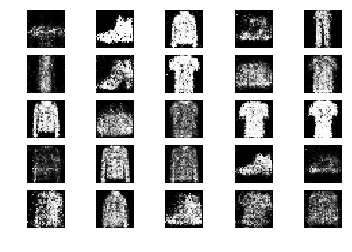

4201 [D loss: 0.638736, acc.: 62.00%] [G loss: 0.937571]
4202 [D loss: 0.673145, acc.: 50.00%] [G loss: 0.923739]
4203 [D loss: 0.645159, acc.: 62.00%] [G loss: 0.904902]
4204 [D loss: 0.667374, acc.: 57.00%] [G loss: 0.848700]
4205 [D loss: 0.657350, acc.: 61.00%] [G loss: 0.832042]
4206 [D loss: 0.652501, acc.: 55.00%] [G loss: 0.820708]
4207 [D loss: 0.660088, acc.: 56.00%] [G loss: 0.764138]
4208 [D loss: 0.674707, acc.: 53.00%] [G loss: 0.878506]
4209 [D loss: 0.675129, acc.: 55.00%] [G loss: 0.856266]
4210 [D loss: 0.666368, acc.: 56.00%] [G loss: 0.828704]
4211 [D loss: 0.678221, acc.: 59.00%] [G loss: 0.882827]
4212 [D loss: 0.672155, acc.: 57.00%] [G loss: 0.842635]
4213 [D loss: 0.669935, acc.: 60.00%] [G loss: 0.835780]
4214 [D loss: 0.679748, acc.: 52.00%] [G loss: 0.858783]
4215 [D loss: 0.636292, acc.: 62.00%] [G loss: 0.902986]
4216 [D loss: 0.638464, acc.: 64.00%] [G loss: 0.893951]
4217 [D loss: 0.630384, acc.: 62.00%] [G loss: 0.864349]
4218 [D loss: 0.710177, acc.: 5

4345 [D loss: 0.660545, acc.: 58.00%] [G loss: 0.893387]
4346 [D loss: 0.684478, acc.: 48.00%] [G loss: 0.869935]
4347 [D loss: 0.687980, acc.: 49.00%] [G loss: 0.854755]
4348 [D loss: 0.662668, acc.: 58.00%] [G loss: 0.853595]
4349 [D loss: 0.660316, acc.: 62.00%] [G loss: 0.896625]
4350 [D loss: 0.620191, acc.: 65.00%] [G loss: 0.841878]
4351 [D loss: 0.650936, acc.: 61.00%] [G loss: 0.950285]
4352 [D loss: 0.656311, acc.: 58.00%] [G loss: 0.900093]
4353 [D loss: 0.630320, acc.: 67.00%] [G loss: 0.841451]
4354 [D loss: 0.660643, acc.: 56.00%] [G loss: 0.894384]
4355 [D loss: 0.664507, acc.: 58.00%] [G loss: 0.892071]
4356 [D loss: 0.692429, acc.: 56.00%] [G loss: 0.943176]
4357 [D loss: 0.662482, acc.: 59.00%] [G loss: 0.883887]
4358 [D loss: 0.680327, acc.: 56.00%] [G loss: 0.864111]
4359 [D loss: 0.636947, acc.: 55.00%] [G loss: 0.902049]
4360 [D loss: 0.656192, acc.: 62.00%] [G loss: 0.959526]
4361 [D loss: 0.661324, acc.: 58.00%] [G loss: 0.918800]
4362 [D loss: 0.660652, acc.: 5

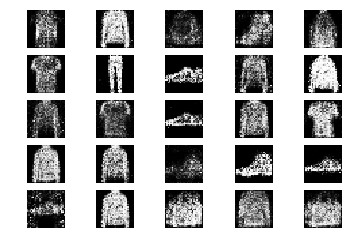

4401 [D loss: 0.659760, acc.: 63.00%] [G loss: 0.842752]
4402 [D loss: 0.654059, acc.: 57.00%] [G loss: 0.846224]
4403 [D loss: 0.667896, acc.: 54.00%] [G loss: 0.850204]
4404 [D loss: 0.669323, acc.: 55.00%] [G loss: 0.806595]
4405 [D loss: 0.644798, acc.: 61.00%] [G loss: 0.816386]
4406 [D loss: 0.664146, acc.: 64.00%] [G loss: 0.884336]
4407 [D loss: 0.649758, acc.: 63.00%] [G loss: 0.910844]
4408 [D loss: 0.682173, acc.: 60.00%] [G loss: 0.894166]
4409 [D loss: 0.670629, acc.: 57.00%] [G loss: 0.833157]
4410 [D loss: 0.649917, acc.: 55.00%] [G loss: 0.892656]
4411 [D loss: 0.621739, acc.: 63.00%] [G loss: 0.945429]
4412 [D loss: 0.668215, acc.: 65.00%] [G loss: 0.885827]
4413 [D loss: 0.658232, acc.: 58.00%] [G loss: 0.847475]
4414 [D loss: 0.630523, acc.: 62.00%] [G loss: 0.876432]
4415 [D loss: 0.618084, acc.: 68.00%] [G loss: 0.848538]
4416 [D loss: 0.610278, acc.: 64.00%] [G loss: 0.875272]
4417 [D loss: 0.647549, acc.: 68.00%] [G loss: 0.866451]
4418 [D loss: 0.653486, acc.: 6

4545 [D loss: 0.619923, acc.: 68.00%] [G loss: 0.866016]
4546 [D loss: 0.682037, acc.: 61.00%] [G loss: 0.884136]
4547 [D loss: 0.633280, acc.: 68.00%] [G loss: 0.926761]
4548 [D loss: 0.697778, acc.: 57.00%] [G loss: 0.858980]
4549 [D loss: 0.679707, acc.: 56.00%] [G loss: 0.829372]
4550 [D loss: 0.637749, acc.: 65.00%] [G loss: 0.890003]
4551 [D loss: 0.590841, acc.: 66.00%] [G loss: 0.861054]
4552 [D loss: 0.690939, acc.: 56.00%] [G loss: 0.890476]
4553 [D loss: 0.671525, acc.: 53.00%] [G loss: 0.900147]
4554 [D loss: 0.652748, acc.: 58.00%] [G loss: 0.862223]
4555 [D loss: 0.642103, acc.: 66.00%] [G loss: 0.878256]
4556 [D loss: 0.638762, acc.: 66.00%] [G loss: 0.889345]
4557 [D loss: 0.667987, acc.: 56.00%] [G loss: 0.907105]
4558 [D loss: 0.634937, acc.: 67.00%] [G loss: 0.924944]
4559 [D loss: 0.709593, acc.: 56.00%] [G loss: 0.899509]
4560 [D loss: 0.670570, acc.: 58.00%] [G loss: 0.834962]
4561 [D loss: 0.681116, acc.: 61.00%] [G loss: 0.849999]
4562 [D loss: 0.656583, acc.: 6

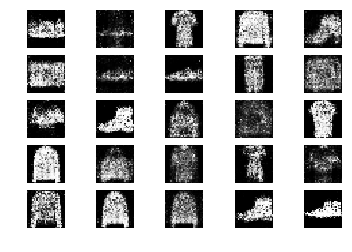

4601 [D loss: 0.657609, acc.: 61.00%] [G loss: 0.831270]
4602 [D loss: 0.686960, acc.: 59.00%] [G loss: 0.890455]
4603 [D loss: 0.629966, acc.: 66.00%] [G loss: 0.947553]
4604 [D loss: 0.674263, acc.: 60.00%] [G loss: 0.844081]
4605 [D loss: 0.625798, acc.: 66.00%] [G loss: 0.922876]
4606 [D loss: 0.661480, acc.: 62.00%] [G loss: 0.882348]
4607 [D loss: 0.662543, acc.: 55.00%] [G loss: 0.891334]
4608 [D loss: 0.698454, acc.: 55.00%] [G loss: 0.855965]
4609 [D loss: 0.650951, acc.: 56.00%] [G loss: 0.860146]
4610 [D loss: 0.592736, acc.: 72.00%] [G loss: 0.839015]
4611 [D loss: 0.665887, acc.: 57.00%] [G loss: 0.844545]
4612 [D loss: 0.618755, acc.: 64.00%] [G loss: 0.909007]
4613 [D loss: 0.654855, acc.: 58.00%] [G loss: 0.892504]
4614 [D loss: 0.637476, acc.: 64.00%] [G loss: 0.910296]
4615 [D loss: 0.684322, acc.: 55.00%] [G loss: 0.892583]
4616 [D loss: 0.630343, acc.: 68.00%] [G loss: 0.909935]
4617 [D loss: 0.612371, acc.: 71.00%] [G loss: 0.819739]
4618 [D loss: 0.641848, acc.: 6

4745 [D loss: 0.663543, acc.: 62.00%] [G loss: 0.878395]
4746 [D loss: 0.676749, acc.: 56.00%] [G loss: 0.868582]
4747 [D loss: 0.675005, acc.: 55.00%] [G loss: 0.860508]
4748 [D loss: 0.657320, acc.: 61.00%] [G loss: 0.867622]
4749 [D loss: 0.696116, acc.: 56.00%] [G loss: 0.904933]
4750 [D loss: 0.668292, acc.: 54.00%] [G loss: 0.910109]
4751 [D loss: 0.625409, acc.: 66.00%] [G loss: 0.834404]
4752 [D loss: 0.689176, acc.: 56.00%] [G loss: 0.812532]
4753 [D loss: 0.683415, acc.: 55.00%] [G loss: 0.794875]
4754 [D loss: 0.694325, acc.: 59.00%] [G loss: 0.894616]
4755 [D loss: 0.632613, acc.: 61.00%] [G loss: 0.843454]
4756 [D loss: 0.631358, acc.: 67.00%] [G loss: 0.860638]
4757 [D loss: 0.685436, acc.: 57.00%] [G loss: 0.863787]
4758 [D loss: 0.645917, acc.: 59.00%] [G loss: 0.877265]
4759 [D loss: 0.621521, acc.: 66.00%] [G loss: 0.964071]
4760 [D loss: 0.640775, acc.: 63.00%] [G loss: 0.900920]
4761 [D loss: 0.665795, acc.: 54.00%] [G loss: 0.873274]
4762 [D loss: 0.668094, acc.: 6

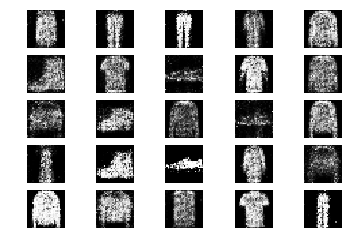

4801 [D loss: 0.668537, acc.: 64.00%] [G loss: 0.900921]
4802 [D loss: 0.650288, acc.: 61.00%] [G loss: 0.879348]
4803 [D loss: 0.657307, acc.: 58.00%] [G loss: 0.839200]
4804 [D loss: 0.679383, acc.: 60.00%] [G loss: 0.880519]
4805 [D loss: 0.669118, acc.: 54.00%] [G loss: 0.847065]
4806 [D loss: 0.638088, acc.: 65.00%] [G loss: 0.891877]
4807 [D loss: 0.664304, acc.: 55.00%] [G loss: 0.820032]
4808 [D loss: 0.650660, acc.: 57.00%] [G loss: 0.873611]
4809 [D loss: 0.618857, acc.: 68.00%] [G loss: 0.851353]
4810 [D loss: 0.661689, acc.: 63.00%] [G loss: 0.868554]
4811 [D loss: 0.652835, acc.: 59.00%] [G loss: 0.915316]
4812 [D loss: 0.652072, acc.: 63.00%] [G loss: 0.864170]
4813 [D loss: 0.677732, acc.: 53.00%] [G loss: 0.865906]
4814 [D loss: 0.686860, acc.: 57.00%] [G loss: 0.919562]
4815 [D loss: 0.683168, acc.: 54.00%] [G loss: 0.897937]
4816 [D loss: 0.677900, acc.: 55.00%] [G loss: 0.896108]
4817 [D loss: 0.671159, acc.: 61.00%] [G loss: 0.850911]
4818 [D loss: 0.665679, acc.: 5

4945 [D loss: 0.645571, acc.: 65.00%] [G loss: 0.824806]
4946 [D loss: 0.645094, acc.: 68.00%] [G loss: 0.868537]
4947 [D loss: 0.632449, acc.: 66.00%] [G loss: 0.879806]
4948 [D loss: 0.687157, acc.: 54.00%] [G loss: 0.898554]
4949 [D loss: 0.659454, acc.: 58.00%] [G loss: 0.870264]
4950 [D loss: 0.674712, acc.: 58.00%] [G loss: 0.874893]
4951 [D loss: 0.649978, acc.: 61.00%] [G loss: 0.840642]
4952 [D loss: 0.653893, acc.: 61.00%] [G loss: 0.880672]
4953 [D loss: 0.643462, acc.: 65.00%] [G loss: 0.873947]
4954 [D loss: 0.695423, acc.: 50.00%] [G loss: 0.856627]
4955 [D loss: 0.622408, acc.: 67.00%] [G loss: 0.893496]
4956 [D loss: 0.652025, acc.: 63.00%] [G loss: 0.858426]
4957 [D loss: 0.644684, acc.: 60.00%] [G loss: 0.838029]
4958 [D loss: 0.637136, acc.: 71.00%] [G loss: 0.871453]
4959 [D loss: 0.626263, acc.: 60.00%] [G loss: 0.862602]
4960 [D loss: 0.661836, acc.: 56.00%] [G loss: 0.876999]
4961 [D loss: 0.676803, acc.: 60.00%] [G loss: 0.901923]
4962 [D loss: 0.640638, acc.: 6

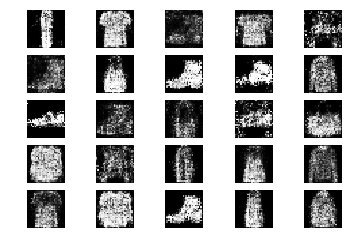

5001 [D loss: 0.669167, acc.: 60.00%] [G loss: 0.887352]
5002 [D loss: 0.647604, acc.: 59.00%] [G loss: 0.870394]
5003 [D loss: 0.670595, acc.: 61.00%] [G loss: 0.852553]
5004 [D loss: 0.657390, acc.: 54.00%] [G loss: 0.850550]
5005 [D loss: 0.637644, acc.: 64.00%] [G loss: 0.858769]
5006 [D loss: 0.709111, acc.: 45.00%] [G loss: 0.905297]
5007 [D loss: 0.648778, acc.: 62.00%] [G loss: 0.910083]
5008 [D loss: 0.708188, acc.: 54.00%] [G loss: 0.915484]
5009 [D loss: 0.625891, acc.: 69.00%] [G loss: 0.883066]
5010 [D loss: 0.682192, acc.: 60.00%] [G loss: 0.876830]
5011 [D loss: 0.616424, acc.: 72.00%] [G loss: 0.874126]
5012 [D loss: 0.651919, acc.: 61.00%] [G loss: 0.849812]
5013 [D loss: 0.626534, acc.: 65.00%] [G loss: 0.834749]
5014 [D loss: 0.634264, acc.: 65.00%] [G loss: 0.887451]
5015 [D loss: 0.686232, acc.: 54.00%] [G loss: 0.845971]
5016 [D loss: 0.689627, acc.: 58.00%] [G loss: 0.854341]
5017 [D loss: 0.634184, acc.: 68.00%] [G loss: 0.914025]
5018 [D loss: 0.660644, acc.: 5

5145 [D loss: 0.680811, acc.: 55.00%] [G loss: 0.892232]
5146 [D loss: 0.686395, acc.: 58.00%] [G loss: 0.839801]
5147 [D loss: 0.640014, acc.: 68.00%] [G loss: 0.845595]
5148 [D loss: 0.609536, acc.: 65.00%] [G loss: 0.838217]
5149 [D loss: 0.632992, acc.: 69.00%] [G loss: 0.871050]
5150 [D loss: 0.626062, acc.: 63.00%] [G loss: 0.907981]
5151 [D loss: 0.689833, acc.: 55.00%] [G loss: 0.985429]
5152 [D loss: 0.641386, acc.: 62.00%] [G loss: 0.941788]
5153 [D loss: 0.656398, acc.: 60.00%] [G loss: 0.849817]
5154 [D loss: 0.636976, acc.: 69.00%] [G loss: 0.885039]
5155 [D loss: 0.652870, acc.: 61.00%] [G loss: 0.859478]
5156 [D loss: 0.657252, acc.: 64.00%] [G loss: 0.883343]
5157 [D loss: 0.650056, acc.: 64.00%] [G loss: 0.919639]
5158 [D loss: 0.695676, acc.: 48.00%] [G loss: 0.925801]
5159 [D loss: 0.696772, acc.: 53.00%] [G loss: 0.927535]
5160 [D loss: 0.647511, acc.: 64.00%] [G loss: 0.873115]
5161 [D loss: 0.631500, acc.: 60.00%] [G loss: 0.871150]
5162 [D loss: 0.651981, acc.: 5

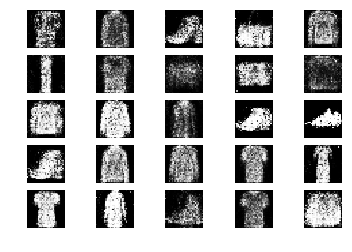

5201 [D loss: 0.637495, acc.: 66.00%] [G loss: 0.852344]
5202 [D loss: 0.638989, acc.: 62.00%] [G loss: 0.853821]
5203 [D loss: 0.641504, acc.: 59.00%] [G loss: 0.883608]
5204 [D loss: 0.679490, acc.: 52.00%] [G loss: 0.912303]
5205 [D loss: 0.672749, acc.: 56.00%] [G loss: 0.945348]
5206 [D loss: 0.649916, acc.: 61.00%] [G loss: 0.885211]
5207 [D loss: 0.684016, acc.: 61.00%] [G loss: 0.844499]
5208 [D loss: 0.644323, acc.: 61.00%] [G loss: 0.869033]
5209 [D loss: 0.720882, acc.: 47.00%] [G loss: 0.817398]
5210 [D loss: 0.670885, acc.: 58.00%] [G loss: 0.875090]
5211 [D loss: 0.614930, acc.: 67.00%] [G loss: 0.892940]
5212 [D loss: 0.662464, acc.: 60.00%] [G loss: 0.826354]
5213 [D loss: 0.639520, acc.: 66.00%] [G loss: 0.860272]
5214 [D loss: 0.651160, acc.: 62.00%] [G loss: 0.868721]
5215 [D loss: 0.664266, acc.: 60.00%] [G loss: 0.923045]
5216 [D loss: 0.673690, acc.: 61.00%] [G loss: 0.894241]
5217 [D loss: 0.662113, acc.: 59.00%] [G loss: 0.849685]
5218 [D loss: 0.676138, acc.: 6

5345 [D loss: 0.630312, acc.: 67.00%] [G loss: 0.866648]
5346 [D loss: 0.639672, acc.: 63.00%] [G loss: 0.848519]
5347 [D loss: 0.643675, acc.: 65.00%] [G loss: 0.918934]
5348 [D loss: 0.661448, acc.: 54.00%] [G loss: 0.916211]
5349 [D loss: 0.575200, acc.: 79.00%] [G loss: 0.932292]
5350 [D loss: 0.649686, acc.: 62.00%] [G loss: 0.887485]
5351 [D loss: 0.666950, acc.: 60.00%] [G loss: 0.907935]
5352 [D loss: 0.648761, acc.: 61.00%] [G loss: 0.900898]
5353 [D loss: 0.704124, acc.: 56.00%] [G loss: 0.878719]
5354 [D loss: 0.628093, acc.: 73.00%] [G loss: 0.891961]
5355 [D loss: 0.615037, acc.: 69.00%] [G loss: 0.928155]
5356 [D loss: 0.643357, acc.: 67.00%] [G loss: 0.895161]
5357 [D loss: 0.706719, acc.: 59.00%] [G loss: 0.854330]
5358 [D loss: 0.619901, acc.: 70.00%] [G loss: 0.869620]
5359 [D loss: 0.621940, acc.: 66.00%] [G loss: 0.832086]
5360 [D loss: 0.676483, acc.: 56.00%] [G loss: 0.845794]
5361 [D loss: 0.632308, acc.: 66.00%] [G loss: 0.922332]
5362 [D loss: 0.615397, acc.: 7

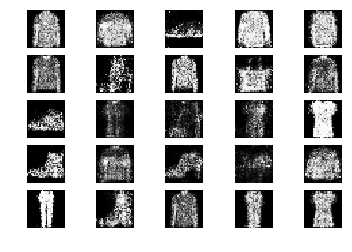

5401 [D loss: 0.693139, acc.: 52.00%] [G loss: 0.895813]
5402 [D loss: 0.682336, acc.: 57.00%] [G loss: 0.870733]
5403 [D loss: 0.650814, acc.: 62.00%] [G loss: 0.914540]
5404 [D loss: 0.648664, acc.: 55.00%] [G loss: 0.855661]
5405 [D loss: 0.714590, acc.: 51.00%] [G loss: 0.924778]
5406 [D loss: 0.649530, acc.: 61.00%] [G loss: 0.868935]
5407 [D loss: 0.662000, acc.: 61.00%] [G loss: 0.895434]
5408 [D loss: 0.659548, acc.: 64.00%] [G loss: 0.882841]
5409 [D loss: 0.694698, acc.: 49.00%] [G loss: 0.856195]
5410 [D loss: 0.628062, acc.: 67.00%] [G loss: 0.909088]
5411 [D loss: 0.679991, acc.: 56.00%] [G loss: 0.899512]
5412 [D loss: 0.611740, acc.: 70.00%] [G loss: 0.946266]
5413 [D loss: 0.633721, acc.: 61.00%] [G loss: 0.942936]
5414 [D loss: 0.632612, acc.: 65.00%] [G loss: 0.875400]
5415 [D loss: 0.643353, acc.: 66.00%] [G loss: 0.927041]
5416 [D loss: 0.633318, acc.: 68.00%] [G loss: 0.894132]
5417 [D loss: 0.664904, acc.: 62.00%] [G loss: 0.857137]
5418 [D loss: 0.622244, acc.: 6

5545 [D loss: 0.654384, acc.: 64.00%] [G loss: 0.898367]
5546 [D loss: 0.661468, acc.: 65.00%] [G loss: 0.893836]
5547 [D loss: 0.672525, acc.: 55.00%] [G loss: 0.843034]
5548 [D loss: 0.664157, acc.: 59.00%] [G loss: 0.872169]
5549 [D loss: 0.643121, acc.: 57.00%] [G loss: 0.888503]
5550 [D loss: 0.689710, acc.: 55.00%] [G loss: 0.918065]
5551 [D loss: 0.691246, acc.: 56.00%] [G loss: 0.952400]
5552 [D loss: 0.631175, acc.: 69.00%] [G loss: 0.892159]
5553 [D loss: 0.674147, acc.: 64.00%] [G loss: 0.925485]
5554 [D loss: 0.697893, acc.: 56.00%] [G loss: 0.894045]
5555 [D loss: 0.673922, acc.: 57.00%] [G loss: 0.875899]
5556 [D loss: 0.666028, acc.: 60.00%] [G loss: 0.870173]
5557 [D loss: 0.656008, acc.: 65.00%] [G loss: 0.851015]
5558 [D loss: 0.680379, acc.: 55.00%] [G loss: 0.843898]
5559 [D loss: 0.677240, acc.: 54.00%] [G loss: 0.848121]
5560 [D loss: 0.687908, acc.: 54.00%] [G loss: 0.860735]
5561 [D loss: 0.704918, acc.: 49.00%] [G loss: 0.893105]
5562 [D loss: 0.664229, acc.: 6

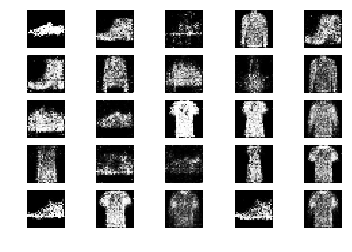

5601 [D loss: 0.623659, acc.: 67.00%] [G loss: 0.840754]
5602 [D loss: 0.613973, acc.: 70.00%] [G loss: 0.847516]
5603 [D loss: 0.674173, acc.: 58.00%] [G loss: 0.821854]
5604 [D loss: 0.679657, acc.: 58.00%] [G loss: 0.808983]
5605 [D loss: 0.675696, acc.: 61.00%] [G loss: 0.854283]
5606 [D loss: 0.676013, acc.: 56.00%] [G loss: 0.862957]
5607 [D loss: 0.679665, acc.: 58.00%] [G loss: 0.865131]
5608 [D loss: 0.655320, acc.: 61.00%] [G loss: 0.858095]
5609 [D loss: 0.636287, acc.: 53.00%] [G loss: 0.947969]
5610 [D loss: 0.662192, acc.: 56.00%] [G loss: 0.841282]
5611 [D loss: 0.666345, acc.: 55.00%] [G loss: 0.857815]
5612 [D loss: 0.672733, acc.: 54.00%] [G loss: 0.877052]
5613 [D loss: 0.689549, acc.: 58.00%] [G loss: 0.858548]
5614 [D loss: 0.637934, acc.: 65.00%] [G loss: 0.847418]
5615 [D loss: 0.661732, acc.: 56.00%] [G loss: 0.854923]
5616 [D loss: 0.678823, acc.: 59.00%] [G loss: 0.811068]
5617 [D loss: 0.678192, acc.: 54.00%] [G loss: 0.885019]
5618 [D loss: 0.630582, acc.: 6

5745 [D loss: 0.680281, acc.: 54.00%] [G loss: 0.842670]
5746 [D loss: 0.646634, acc.: 63.00%] [G loss: 0.804034]
5747 [D loss: 0.679589, acc.: 56.00%] [G loss: 0.881585]
5748 [D loss: 0.671099, acc.: 62.00%] [G loss: 0.820257]
5749 [D loss: 0.707632, acc.: 59.00%] [G loss: 0.838175]
5750 [D loss: 0.671471, acc.: 62.00%] [G loss: 0.828539]
5751 [D loss: 0.705959, acc.: 54.00%] [G loss: 0.873355]
5752 [D loss: 0.626403, acc.: 72.00%] [G loss: 0.912437]
5753 [D loss: 0.705039, acc.: 58.00%] [G loss: 0.913979]
5754 [D loss: 0.623449, acc.: 62.00%] [G loss: 0.850202]
5755 [D loss: 0.695912, acc.: 54.00%] [G loss: 0.875307]
5756 [D loss: 0.624807, acc.: 62.00%] [G loss: 0.872873]
5757 [D loss: 0.694122, acc.: 57.00%] [G loss: 0.892502]
5758 [D loss: 0.649885, acc.: 67.00%] [G loss: 0.920734]
5759 [D loss: 0.618289, acc.: 64.00%] [G loss: 0.856851]
5760 [D loss: 0.659573, acc.: 62.00%] [G loss: 0.874787]
5761 [D loss: 0.671577, acc.: 63.00%] [G loss: 0.904454]
5762 [D loss: 0.663257, acc.: 6

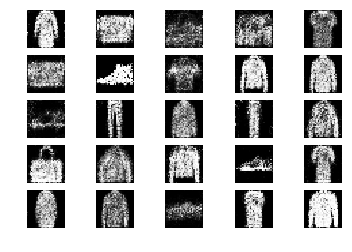

5801 [D loss: 0.612612, acc.: 73.00%] [G loss: 0.924051]
5802 [D loss: 0.665107, acc.: 57.00%] [G loss: 0.975654]
5803 [D loss: 0.655781, acc.: 63.00%] [G loss: 0.935710]
5804 [D loss: 0.614643, acc.: 64.00%] [G loss: 0.930560]
5805 [D loss: 0.667850, acc.: 56.00%] [G loss: 0.863328]
5806 [D loss: 0.635384, acc.: 69.00%] [G loss: 0.887956]
5807 [D loss: 0.621729, acc.: 64.00%] [G loss: 0.870886]
5808 [D loss: 0.634590, acc.: 66.00%] [G loss: 0.842940]
5809 [D loss: 0.611898, acc.: 72.00%] [G loss: 0.796707]
5810 [D loss: 0.642518, acc.: 70.00%] [G loss: 0.918758]
5811 [D loss: 0.670335, acc.: 57.00%] [G loss: 0.824659]
5812 [D loss: 0.672596, acc.: 56.00%] [G loss: 0.902555]
5813 [D loss: 0.649835, acc.: 60.00%] [G loss: 0.899431]
5814 [D loss: 0.656894, acc.: 64.00%] [G loss: 0.912588]
5815 [D loss: 0.651088, acc.: 61.00%] [G loss: 0.926808]
5816 [D loss: 0.671661, acc.: 58.00%] [G loss: 0.879700]
5817 [D loss: 0.667668, acc.: 62.00%] [G loss: 0.833641]
5818 [D loss: 0.637968, acc.: 6

5945 [D loss: 0.621513, acc.: 67.00%] [G loss: 0.899276]
5946 [D loss: 0.665019, acc.: 60.00%] [G loss: 0.937395]
5947 [D loss: 0.659799, acc.: 56.00%] [G loss: 0.900194]
5948 [D loss: 0.650621, acc.: 60.00%] [G loss: 0.845050]
5949 [D loss: 0.646857, acc.: 62.00%] [G loss: 0.869311]
5950 [D loss: 0.691235, acc.: 57.00%] [G loss: 0.820930]
5951 [D loss: 0.624056, acc.: 68.00%] [G loss: 0.894706]
5952 [D loss: 0.732300, acc.: 47.00%] [G loss: 0.851964]
5953 [D loss: 0.665582, acc.: 63.00%] [G loss: 0.894306]
5954 [D loss: 0.638963, acc.: 59.00%] [G loss: 0.839661]
5955 [D loss: 0.667172, acc.: 60.00%] [G loss: 0.915549]
5956 [D loss: 0.665566, acc.: 58.00%] [G loss: 0.813642]
5957 [D loss: 0.679861, acc.: 60.00%] [G loss: 0.870679]
5958 [D loss: 0.656906, acc.: 63.00%] [G loss: 0.907751]
5959 [D loss: 0.666360, acc.: 59.00%] [G loss: 0.864674]
5960 [D loss: 0.624509, acc.: 66.00%] [G loss: 0.942416]
5961 [D loss: 0.644718, acc.: 61.00%] [G loss: 0.828456]
5962 [D loss: 0.673936, acc.: 5

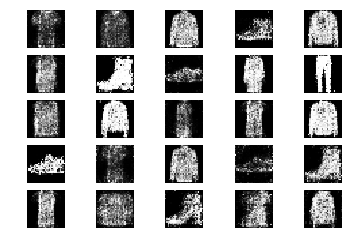

6001 [D loss: 0.665494, acc.: 58.00%] [G loss: 0.892410]
6002 [D loss: 0.660676, acc.: 64.00%] [G loss: 0.976732]
6003 [D loss: 0.687435, acc.: 54.00%] [G loss: 0.920355]
6004 [D loss: 0.653286, acc.: 63.00%] [G loss: 0.841826]
6005 [D loss: 0.647774, acc.: 63.00%] [G loss: 0.864521]
6006 [D loss: 0.663596, acc.: 60.00%] [G loss: 0.874321]
6007 [D loss: 0.638079, acc.: 65.00%] [G loss: 0.840205]
6008 [D loss: 0.626729, acc.: 65.00%] [G loss: 0.820596]
6009 [D loss: 0.684089, acc.: 62.00%] [G loss: 0.810736]
6010 [D loss: 0.657194, acc.: 53.00%] [G loss: 0.872814]
6011 [D loss: 0.650697, acc.: 53.00%] [G loss: 0.889751]
6012 [D loss: 0.611145, acc.: 65.00%] [G loss: 0.875643]
6013 [D loss: 0.685586, acc.: 57.00%] [G loss: 0.819485]
6014 [D loss: 0.666230, acc.: 56.00%] [G loss: 0.841510]
6015 [D loss: 0.677758, acc.: 56.00%] [G loss: 0.866752]
6016 [D loss: 0.663139, acc.: 67.00%] [G loss: 0.851556]
6017 [D loss: 0.677190, acc.: 62.00%] [G loss: 0.852853]
6018 [D loss: 0.641408, acc.: 6

6146 [D loss: 0.658292, acc.: 61.00%] [G loss: 0.863463]
6147 [D loss: 0.693294, acc.: 54.00%] [G loss: 0.846751]
6148 [D loss: 0.654663, acc.: 60.00%] [G loss: 0.808838]
6149 [D loss: 0.691783, acc.: 55.00%] [G loss: 0.859370]
6150 [D loss: 0.651037, acc.: 63.00%] [G loss: 0.854874]
6151 [D loss: 0.609270, acc.: 73.00%] [G loss: 0.888152]
6152 [D loss: 0.671427, acc.: 55.00%] [G loss: 0.838670]
6153 [D loss: 0.668677, acc.: 60.00%] [G loss: 0.803427]
6154 [D loss: 0.677359, acc.: 57.00%] [G loss: 0.877970]
6155 [D loss: 0.677526, acc.: 62.00%] [G loss: 0.898413]
6156 [D loss: 0.711592, acc.: 55.00%] [G loss: 0.856909]
6157 [D loss: 0.631052, acc.: 71.00%] [G loss: 0.825674]
6158 [D loss: 0.662620, acc.: 65.00%] [G loss: 0.914350]
6159 [D loss: 0.671946, acc.: 64.00%] [G loss: 0.887428]
6160 [D loss: 0.628508, acc.: 63.00%] [G loss: 0.902645]
6161 [D loss: 0.670610, acc.: 63.00%] [G loss: 0.853510]
6162 [D loss: 0.671504, acc.: 59.00%] [G loss: 0.884731]
6163 [D loss: 0.673627, acc.: 5

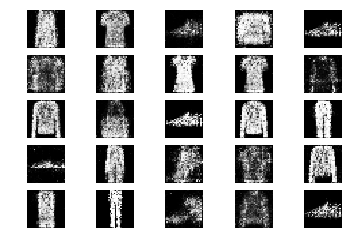

6201 [D loss: 0.640297, acc.: 70.00%] [G loss: 0.885251]
6202 [D loss: 0.697282, acc.: 52.00%] [G loss: 0.803733]
6203 [D loss: 0.630317, acc.: 61.00%] [G loss: 0.785613]
6204 [D loss: 0.651391, acc.: 65.00%] [G loss: 0.821826]
6205 [D loss: 0.640869, acc.: 63.00%] [G loss: 0.830707]
6206 [D loss: 0.666143, acc.: 57.00%] [G loss: 0.870724]
6207 [D loss: 0.663640, acc.: 60.00%] [G loss: 0.817866]
6208 [D loss: 0.648335, acc.: 64.00%] [G loss: 0.884580]
6209 [D loss: 0.717855, acc.: 51.00%] [G loss: 0.843213]
6210 [D loss: 0.668002, acc.: 54.00%] [G loss: 0.895788]
6211 [D loss: 0.636615, acc.: 66.00%] [G loss: 0.864749]
6212 [D loss: 0.660679, acc.: 62.00%] [G loss: 0.837919]
6213 [D loss: 0.640377, acc.: 62.00%] [G loss: 0.867865]
6214 [D loss: 0.646177, acc.: 61.00%] [G loss: 0.879046]
6215 [D loss: 0.719729, acc.: 49.00%] [G loss: 0.940366]
6216 [D loss: 0.645680, acc.: 66.00%] [G loss: 0.934185]
6217 [D loss: 0.660240, acc.: 65.00%] [G loss: 0.888615]
6218 [D loss: 0.692425, acc.: 5

6345 [D loss: 0.696745, acc.: 59.00%] [G loss: 0.914193]
6346 [D loss: 0.685597, acc.: 52.00%] [G loss: 0.771489]
6347 [D loss: 0.673486, acc.: 57.00%] [G loss: 0.816300]
6348 [D loss: 0.660921, acc.: 64.00%] [G loss: 0.856157]
6349 [D loss: 0.620592, acc.: 74.00%] [G loss: 0.933305]
6350 [D loss: 0.669348, acc.: 51.00%] [G loss: 0.908018]
6351 [D loss: 0.699257, acc.: 51.00%] [G loss: 0.893044]
6352 [D loss: 0.639104, acc.: 65.00%] [G loss: 0.849394]
6353 [D loss: 0.682867, acc.: 55.00%] [G loss: 0.871489]
6354 [D loss: 0.675409, acc.: 50.00%] [G loss: 0.895260]
6355 [D loss: 0.686378, acc.: 54.00%] [G loss: 0.944088]
6356 [D loss: 0.640906, acc.: 68.00%] [G loss: 0.916343]
6357 [D loss: 0.676375, acc.: 61.00%] [G loss: 0.896382]
6358 [D loss: 0.666220, acc.: 66.00%] [G loss: 0.919036]
6359 [D loss: 0.656071, acc.: 58.00%] [G loss: 0.871147]
6360 [D loss: 0.652450, acc.: 64.00%] [G loss: 0.909081]
6361 [D loss: 0.668274, acc.: 65.00%] [G loss: 0.841009]
6362 [D loss: 0.633084, acc.: 6

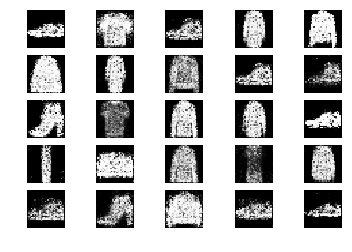

6401 [D loss: 0.673031, acc.: 59.00%] [G loss: 0.877365]
6402 [D loss: 0.655748, acc.: 61.00%] [G loss: 0.884751]
6403 [D loss: 0.692765, acc.: 57.00%] [G loss: 0.820873]
6404 [D loss: 0.634125, acc.: 58.00%] [G loss: 0.888552]
6405 [D loss: 0.644996, acc.: 63.00%] [G loss: 0.863604]
6406 [D loss: 0.645846, acc.: 59.00%] [G loss: 0.864895]
6407 [D loss: 0.682624, acc.: 58.00%] [G loss: 0.909458]
6408 [D loss: 0.679416, acc.: 55.00%] [G loss: 0.840912]
6409 [D loss: 0.632207, acc.: 64.00%] [G loss: 0.841051]
6410 [D loss: 0.670119, acc.: 61.00%] [G loss: 0.916825]
6411 [D loss: 0.679172, acc.: 57.00%] [G loss: 0.793330]
6412 [D loss: 0.657080, acc.: 52.00%] [G loss: 0.836960]
6413 [D loss: 0.597647, acc.: 70.00%] [G loss: 0.800807]
6414 [D loss: 0.635049, acc.: 68.00%] [G loss: 0.838416]
6415 [D loss: 0.666345, acc.: 62.00%] [G loss: 0.856137]
6416 [D loss: 0.643793, acc.: 71.00%] [G loss: 0.906704]
6417 [D loss: 0.693317, acc.: 60.00%] [G loss: 0.898430]
6418 [D loss: 0.644052, acc.: 6

6546 [D loss: 0.635379, acc.: 61.00%] [G loss: 0.921026]
6547 [D loss: 0.645541, acc.: 62.00%] [G loss: 0.866896]
6548 [D loss: 0.675344, acc.: 65.00%] [G loss: 0.846722]
6549 [D loss: 0.657103, acc.: 62.00%] [G loss: 0.853631]
6550 [D loss: 0.677618, acc.: 53.00%] [G loss: 0.925469]
6551 [D loss: 0.675405, acc.: 61.00%] [G loss: 0.942227]
6552 [D loss: 0.690711, acc.: 57.00%] [G loss: 0.847444]
6553 [D loss: 0.648775, acc.: 56.00%] [G loss: 0.872514]
6554 [D loss: 0.634076, acc.: 62.00%] [G loss: 0.911117]
6555 [D loss: 0.648529, acc.: 64.00%] [G loss: 0.858356]
6556 [D loss: 0.717204, acc.: 47.00%] [G loss: 0.891759]
6557 [D loss: 0.643541, acc.: 59.00%] [G loss: 0.886644]
6558 [D loss: 0.628546, acc.: 62.00%] [G loss: 0.867443]
6559 [D loss: 0.687089, acc.: 56.00%] [G loss: 0.956800]
6560 [D loss: 0.656607, acc.: 62.00%] [G loss: 0.850742]
6561 [D loss: 0.666120, acc.: 57.00%] [G loss: 0.857032]
6562 [D loss: 0.656898, acc.: 64.00%] [G loss: 0.894299]
6563 [D loss: 0.655932, acc.: 5

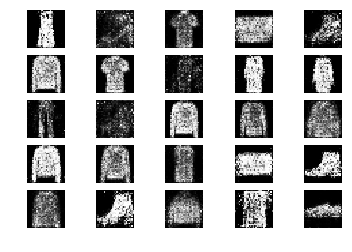

6601 [D loss: 0.674390, acc.: 58.00%] [G loss: 0.851445]
6602 [D loss: 0.711536, acc.: 52.00%] [G loss: 0.901597]
6603 [D loss: 0.699327, acc.: 53.00%] [G loss: 0.912862]
6604 [D loss: 0.659294, acc.: 68.00%] [G loss: 0.929943]
6605 [D loss: 0.656194, acc.: 61.00%] [G loss: 0.885412]
6606 [D loss: 0.650132, acc.: 64.00%] [G loss: 0.859423]
6607 [D loss: 0.692256, acc.: 52.00%] [G loss: 0.813850]
6608 [D loss: 0.655475, acc.: 63.00%] [G loss: 0.850888]
6609 [D loss: 0.641372, acc.: 63.00%] [G loss: 0.844638]
6610 [D loss: 0.654089, acc.: 62.00%] [G loss: 0.892805]
6611 [D loss: 0.632190, acc.: 67.00%] [G loss: 0.830867]
6612 [D loss: 0.687737, acc.: 58.00%] [G loss: 0.920722]
6613 [D loss: 0.672237, acc.: 58.00%] [G loss: 0.821298]
6614 [D loss: 0.624269, acc.: 72.00%] [G loss: 0.938593]
6615 [D loss: 0.666219, acc.: 63.00%] [G loss: 0.931519]
6616 [D loss: 0.649850, acc.: 58.00%] [G loss: 0.896918]
6617 [D loss: 0.650190, acc.: 63.00%] [G loss: 0.908946]
6618 [D loss: 0.708460, acc.: 5

6745 [D loss: 0.697797, acc.: 52.00%] [G loss: 0.883455]
6746 [D loss: 0.666276, acc.: 54.00%] [G loss: 0.906959]
6747 [D loss: 0.668341, acc.: 53.00%] [G loss: 0.861516]
6748 [D loss: 0.629153, acc.: 61.00%] [G loss: 0.865156]
6749 [D loss: 0.742921, acc.: 44.00%] [G loss: 0.850820]
6750 [D loss: 0.655524, acc.: 58.00%] [G loss: 0.797015]
6751 [D loss: 0.676384, acc.: 59.00%] [G loss: 0.878477]
6752 [D loss: 0.649543, acc.: 64.00%] [G loss: 0.904162]
6753 [D loss: 0.675733, acc.: 61.00%] [G loss: 0.899728]
6754 [D loss: 0.612808, acc.: 74.00%] [G loss: 0.830313]
6755 [D loss: 0.647496, acc.: 62.00%] [G loss: 0.877142]
6756 [D loss: 0.635570, acc.: 64.00%] [G loss: 0.855440]
6757 [D loss: 0.626446, acc.: 64.00%] [G loss: 0.868984]
6758 [D loss: 0.654870, acc.: 61.00%] [G loss: 0.803076]
6759 [D loss: 0.668891, acc.: 58.00%] [G loss: 0.855383]
6760 [D loss: 0.611569, acc.: 72.00%] [G loss: 0.866477]
6761 [D loss: 0.669317, acc.: 62.00%] [G loss: 0.871626]
6762 [D loss: 0.626542, acc.: 6

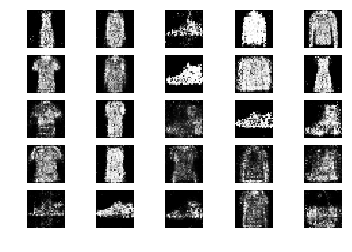

6801 [D loss: 0.691020, acc.: 57.00%] [G loss: 0.883606]
6802 [D loss: 0.653614, acc.: 57.00%] [G loss: 0.870251]
6803 [D loss: 0.654651, acc.: 57.00%] [G loss: 0.846819]
6804 [D loss: 0.667492, acc.: 61.00%] [G loss: 0.912081]
6805 [D loss: 0.685504, acc.: 52.00%] [G loss: 0.908875]
6806 [D loss: 0.654734, acc.: 62.00%] [G loss: 0.935565]
6807 [D loss: 0.631616, acc.: 73.00%] [G loss: 0.893313]
6808 [D loss: 0.698213, acc.: 56.00%] [G loss: 0.901561]
6809 [D loss: 0.676153, acc.: 58.00%] [G loss: 0.834218]
6810 [D loss: 0.697349, acc.: 54.00%] [G loss: 0.854094]
6811 [D loss: 0.626284, acc.: 71.00%] [G loss: 0.818718]
6812 [D loss: 0.701189, acc.: 55.00%] [G loss: 0.805446]
6813 [D loss: 0.689031, acc.: 56.00%] [G loss: 0.801797]
6814 [D loss: 0.641164, acc.: 58.00%] [G loss: 0.824619]
6815 [D loss: 0.661239, acc.: 64.00%] [G loss: 0.870734]
6816 [D loss: 0.651650, acc.: 65.00%] [G loss: 0.847652]
6817 [D loss: 0.670745, acc.: 58.00%] [G loss: 0.879057]
6818 [D loss: 0.672161, acc.: 6

6945 [D loss: 0.692132, acc.: 53.00%] [G loss: 0.840504]
6946 [D loss: 0.617962, acc.: 65.00%] [G loss: 0.803955]
6947 [D loss: 0.648346, acc.: 62.00%] [G loss: 0.822766]
6948 [D loss: 0.696950, acc.: 52.00%] [G loss: 0.909288]
6949 [D loss: 0.578202, acc.: 72.00%] [G loss: 0.898593]
6950 [D loss: 0.732346, acc.: 54.00%] [G loss: 0.790994]
6951 [D loss: 0.713933, acc.: 51.00%] [G loss: 0.871711]
6952 [D loss: 0.663784, acc.: 63.00%] [G loss: 0.867431]
6953 [D loss: 0.666374, acc.: 59.00%] [G loss: 0.893950]
6954 [D loss: 0.687523, acc.: 58.00%] [G loss: 0.951833]
6955 [D loss: 0.675585, acc.: 54.00%] [G loss: 0.901842]
6956 [D loss: 0.677604, acc.: 60.00%] [G loss: 0.842217]
6957 [D loss: 0.671825, acc.: 57.00%] [G loss: 0.901052]
6958 [D loss: 0.700404, acc.: 56.00%] [G loss: 0.885370]
6959 [D loss: 0.653783, acc.: 56.00%] [G loss: 0.965620]
6960 [D loss: 0.633956, acc.: 67.00%] [G loss: 0.865165]
6961 [D loss: 0.681446, acc.: 59.00%] [G loss: 0.841493]
6962 [D loss: 0.649504, acc.: 6

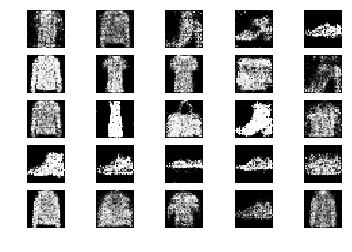

7001 [D loss: 0.679979, acc.: 60.00%] [G loss: 0.869325]
7002 [D loss: 0.698110, acc.: 51.00%] [G loss: 0.809300]
7003 [D loss: 0.718775, acc.: 52.00%] [G loss: 0.827936]
7004 [D loss: 0.659262, acc.: 67.00%] [G loss: 0.832645]
7005 [D loss: 0.664049, acc.: 60.00%] [G loss: 0.837994]
7006 [D loss: 0.663128, acc.: 53.00%] [G loss: 0.828713]
7007 [D loss: 0.632749, acc.: 66.00%] [G loss: 0.896937]
7008 [D loss: 0.641469, acc.: 62.00%] [G loss: 0.915106]
7009 [D loss: 0.656457, acc.: 67.00%] [G loss: 0.915912]
7010 [D loss: 0.654465, acc.: 62.00%] [G loss: 0.908256]
7011 [D loss: 0.686451, acc.: 57.00%] [G loss: 0.878463]
7012 [D loss: 0.670317, acc.: 53.00%] [G loss: 0.863958]
7013 [D loss: 0.622738, acc.: 66.00%] [G loss: 0.820561]
7014 [D loss: 0.661007, acc.: 62.00%] [G loss: 0.807270]
7015 [D loss: 0.642499, acc.: 58.00%] [G loss: 0.821731]
7016 [D loss: 0.645602, acc.: 63.00%] [G loss: 0.845912]
7017 [D loss: 0.649315, acc.: 67.00%] [G loss: 0.858753]
7018 [D loss: 0.737459, acc.: 5

7146 [D loss: 0.663375, acc.: 60.00%] [G loss: 0.862554]
7147 [D loss: 0.695790, acc.: 56.00%] [G loss: 0.826372]
7148 [D loss: 0.647647, acc.: 64.00%] [G loss: 0.867205]
7149 [D loss: 0.715114, acc.: 52.00%] [G loss: 0.894528]
7150 [D loss: 0.619524, acc.: 72.00%] [G loss: 0.937663]
7151 [D loss: 0.723045, acc.: 42.00%] [G loss: 0.850445]
7152 [D loss: 0.638165, acc.: 63.00%] [G loss: 0.868025]
7153 [D loss: 0.694293, acc.: 57.00%] [G loss: 0.836195]
7154 [D loss: 0.707659, acc.: 51.00%] [G loss: 0.871684]
7155 [D loss: 0.675989, acc.: 53.00%] [G loss: 0.912965]
7156 [D loss: 0.686155, acc.: 51.00%] [G loss: 0.850376]
7157 [D loss: 0.683791, acc.: 54.00%] [G loss: 0.854964]
7158 [D loss: 0.673942, acc.: 62.00%] [G loss: 0.862525]
7159 [D loss: 0.659948, acc.: 62.00%] [G loss: 0.823100]
7160 [D loss: 0.652986, acc.: 61.00%] [G loss: 0.876393]
7161 [D loss: 0.693038, acc.: 56.00%] [G loss: 0.837011]
7162 [D loss: 0.665993, acc.: 63.00%] [G loss: 0.892517]
7163 [D loss: 0.684257, acc.: 5

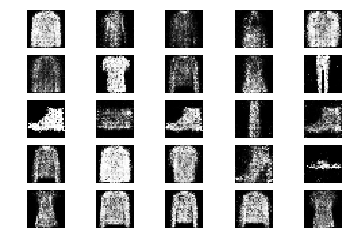

7201 [D loss: 0.635329, acc.: 69.00%] [G loss: 0.903689]
7202 [D loss: 0.670213, acc.: 59.00%] [G loss: 0.919095]
7203 [D loss: 0.660592, acc.: 64.00%] [G loss: 0.835623]
7204 [D loss: 0.632964, acc.: 66.00%] [G loss: 0.869895]
7205 [D loss: 0.624893, acc.: 69.00%] [G loss: 0.827819]
7206 [D loss: 0.679466, acc.: 55.00%] [G loss: 0.833844]
7207 [D loss: 0.656878, acc.: 61.00%] [G loss: 0.889195]
7208 [D loss: 0.637612, acc.: 67.00%] [G loss: 0.887190]
7209 [D loss: 0.733704, acc.: 52.00%] [G loss: 0.849340]
7210 [D loss: 0.661372, acc.: 59.00%] [G loss: 0.837194]
7211 [D loss: 0.651494, acc.: 63.00%] [G loss: 0.796943]
7212 [D loss: 0.656962, acc.: 63.00%] [G loss: 0.815950]
7213 [D loss: 0.637575, acc.: 68.00%] [G loss: 0.845763]
7214 [D loss: 0.660979, acc.: 62.00%] [G loss: 0.839266]
7215 [D loss: 0.659551, acc.: 64.00%] [G loss: 0.862624]
7216 [D loss: 0.639228, acc.: 65.00%] [G loss: 0.951270]
7217 [D loss: 0.679790, acc.: 62.00%] [G loss: 0.905866]
7218 [D loss: 0.647637, acc.: 6

7346 [D loss: 0.709056, acc.: 48.00%] [G loss: 0.885891]
7347 [D loss: 0.641686, acc.: 65.00%] [G loss: 0.906349]
7348 [D loss: 0.658690, acc.: 57.00%] [G loss: 0.887019]
7349 [D loss: 0.647476, acc.: 68.00%] [G loss: 0.874806]
7350 [D loss: 0.630747, acc.: 66.00%] [G loss: 0.853174]
7351 [D loss: 0.626137, acc.: 66.00%] [G loss: 0.844461]
7352 [D loss: 0.682388, acc.: 55.00%] [G loss: 0.868219]
7353 [D loss: 0.659152, acc.: 55.00%] [G loss: 0.860692]
7354 [D loss: 0.686428, acc.: 53.00%] [G loss: 0.852639]
7355 [D loss: 0.658099, acc.: 60.00%] [G loss: 0.851447]
7356 [D loss: 0.684827, acc.: 51.00%] [G loss: 0.834040]
7357 [D loss: 0.672929, acc.: 59.00%] [G loss: 0.855730]
7358 [D loss: 0.651580, acc.: 62.00%] [G loss: 0.868242]
7359 [D loss: 0.656721, acc.: 55.00%] [G loss: 0.840618]
7360 [D loss: 0.650512, acc.: 56.00%] [G loss: 0.797653]
7361 [D loss: 0.680634, acc.: 56.00%] [G loss: 0.782722]
7362 [D loss: 0.680340, acc.: 55.00%] [G loss: 0.837143]
7363 [D loss: 0.652548, acc.: 6

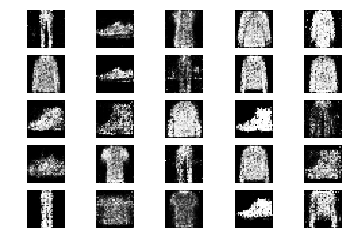

7401 [D loss: 0.666297, acc.: 54.00%] [G loss: 0.806379]
7402 [D loss: 0.687154, acc.: 63.00%] [G loss: 0.824169]
7403 [D loss: 0.635849, acc.: 67.00%] [G loss: 0.902784]
7404 [D loss: 0.647355, acc.: 68.00%] [G loss: 0.851465]
7405 [D loss: 0.668990, acc.: 63.00%] [G loss: 0.927425]
7406 [D loss: 0.624896, acc.: 62.00%] [G loss: 0.854374]
7407 [D loss: 0.627304, acc.: 68.00%] [G loss: 0.880233]
7408 [D loss: 0.684632, acc.: 60.00%] [G loss: 0.937656]
7409 [D loss: 0.664200, acc.: 58.00%] [G loss: 0.795945]
7410 [D loss: 0.645777, acc.: 60.00%] [G loss: 0.885682]
7411 [D loss: 0.653009, acc.: 65.00%] [G loss: 0.835440]
7412 [D loss: 0.657360, acc.: 60.00%] [G loss: 0.902613]
7413 [D loss: 0.671593, acc.: 54.00%] [G loss: 0.883931]
7414 [D loss: 0.632104, acc.: 61.00%] [G loss: 0.893445]
7415 [D loss: 0.690821, acc.: 51.00%] [G loss: 0.837320]
7416 [D loss: 0.645316, acc.: 63.00%] [G loss: 0.901869]
7417 [D loss: 0.660395, acc.: 54.00%] [G loss: 0.940513]
7418 [D loss: 0.650384, acc.: 6

7545 [D loss: 0.642424, acc.: 64.00%] [G loss: 0.811268]
7546 [D loss: 0.679068, acc.: 59.00%] [G loss: 0.781215]
7547 [D loss: 0.657983, acc.: 58.00%] [G loss: 0.782947]
7548 [D loss: 0.663266, acc.: 56.00%] [G loss: 0.750693]
7549 [D loss: 0.673483, acc.: 64.00%] [G loss: 0.844639]
7550 [D loss: 0.631603, acc.: 64.00%] [G loss: 0.864488]
7551 [D loss: 0.626076, acc.: 63.00%] [G loss: 0.858914]
7552 [D loss: 0.668247, acc.: 57.00%] [G loss: 0.874126]
7553 [D loss: 0.641297, acc.: 56.00%] [G loss: 0.886540]
7554 [D loss: 0.623076, acc.: 65.00%] [G loss: 0.928131]
7555 [D loss: 0.603791, acc.: 70.00%] [G loss: 0.874691]
7556 [D loss: 0.661814, acc.: 65.00%] [G loss: 0.863333]
7557 [D loss: 0.615879, acc.: 69.00%] [G loss: 0.838441]
7558 [D loss: 0.624720, acc.: 67.00%] [G loss: 0.819001]
7559 [D loss: 0.745545, acc.: 45.00%] [G loss: 0.858816]
7560 [D loss: 0.705264, acc.: 57.00%] [G loss: 0.826451]
7561 [D loss: 0.681109, acc.: 57.00%] [G loss: 0.867247]
7562 [D loss: 0.696297, acc.: 5

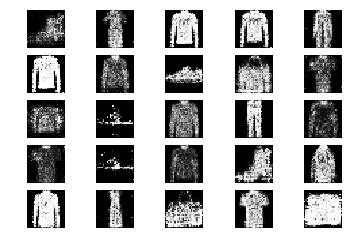

7601 [D loss: 0.665707, acc.: 57.00%] [G loss: 0.842629]
7602 [D loss: 0.670025, acc.: 59.00%] [G loss: 0.826868]
7603 [D loss: 0.662682, acc.: 58.00%] [G loss: 0.903005]
7604 [D loss: 0.673468, acc.: 64.00%] [G loss: 0.841412]
7605 [D loss: 0.671777, acc.: 64.00%] [G loss: 0.861446]
7606 [D loss: 0.714213, acc.: 56.00%] [G loss: 0.891791]
7607 [D loss: 0.706867, acc.: 57.00%] [G loss: 0.886619]
7608 [D loss: 0.639904, acc.: 62.00%] [G loss: 0.863923]
7609 [D loss: 0.645847, acc.: 68.00%] [G loss: 0.884129]
7610 [D loss: 0.654464, acc.: 68.00%] [G loss: 0.859167]
7611 [D loss: 0.670649, acc.: 59.00%] [G loss: 0.846980]
7612 [D loss: 0.675971, acc.: 60.00%] [G loss: 0.856444]
7613 [D loss: 0.690327, acc.: 54.00%] [G loss: 0.834913]
7614 [D loss: 0.717935, acc.: 53.00%] [G loss: 0.824156]
7615 [D loss: 0.665209, acc.: 53.00%] [G loss: 0.852438]
7616 [D loss: 0.652601, acc.: 57.00%] [G loss: 0.882051]
7617 [D loss: 0.677577, acc.: 56.00%] [G loss: 0.915792]
7618 [D loss: 0.687100, acc.: 5

7746 [D loss: 0.684621, acc.: 52.00%] [G loss: 0.869536]
7747 [D loss: 0.647741, acc.: 60.00%] [G loss: 0.840631]
7748 [D loss: 0.675636, acc.: 59.00%] [G loss: 0.860855]
7749 [D loss: 0.694683, acc.: 51.00%] [G loss: 0.865322]
7750 [D loss: 0.629483, acc.: 62.00%] [G loss: 0.885435]
7751 [D loss: 0.719379, acc.: 46.00%] [G loss: 0.876133]
7752 [D loss: 0.668584, acc.: 58.00%] [G loss: 0.841797]
7753 [D loss: 0.704606, acc.: 46.00%] [G loss: 0.845319]
7754 [D loss: 0.668284, acc.: 58.00%] [G loss: 0.874239]
7755 [D loss: 0.692399, acc.: 55.00%] [G loss: 0.809319]
7756 [D loss: 0.648757, acc.: 60.00%] [G loss: 0.917038]
7757 [D loss: 0.669201, acc.: 61.00%] [G loss: 0.892272]
7758 [D loss: 0.696419, acc.: 53.00%] [G loss: 0.894210]
7759 [D loss: 0.643494, acc.: 65.00%] [G loss: 0.844850]
7760 [D loss: 0.626761, acc.: 65.00%] [G loss: 0.826737]
7761 [D loss: 0.660687, acc.: 64.00%] [G loss: 0.843943]
7762 [D loss: 0.631767, acc.: 63.00%] [G loss: 0.842343]
7763 [D loss: 0.659665, acc.: 5

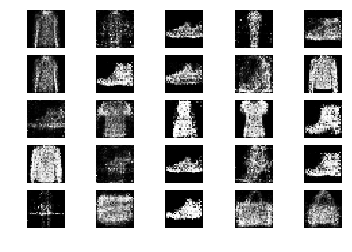

7801 [D loss: 0.675820, acc.: 59.00%] [G loss: 0.822715]
7802 [D loss: 0.671711, acc.: 54.00%] [G loss: 0.845183]
7803 [D loss: 0.628785, acc.: 68.00%] [G loss: 0.837220]
7804 [D loss: 0.718215, acc.: 53.00%] [G loss: 0.845126]
7805 [D loss: 0.711287, acc.: 53.00%] [G loss: 0.818633]
7806 [D loss: 0.680550, acc.: 55.00%] [G loss: 0.834143]
7807 [D loss: 0.660100, acc.: 63.00%] [G loss: 0.874831]
7808 [D loss: 0.641305, acc.: 64.00%] [G loss: 0.918706]
7809 [D loss: 0.684931, acc.: 60.00%] [G loss: 0.896146]
7810 [D loss: 0.670758, acc.: 60.00%] [G loss: 0.867547]
7811 [D loss: 0.627162, acc.: 63.00%] [G loss: 0.831193]
7812 [D loss: 0.647240, acc.: 61.00%] [G loss: 0.864031]
7813 [D loss: 0.683677, acc.: 59.00%] [G loss: 0.815712]
7814 [D loss: 0.656421, acc.: 63.00%] [G loss: 0.834849]
7815 [D loss: 0.696923, acc.: 52.00%] [G loss: 0.883320]
7816 [D loss: 0.675550, acc.: 58.00%] [G loss: 0.822937]
7817 [D loss: 0.647559, acc.: 64.00%] [G loss: 0.857638]
7818 [D loss: 0.625593, acc.: 6

7945 [D loss: 0.644386, acc.: 60.00%] [G loss: 0.868433]
7946 [D loss: 0.651842, acc.: 61.00%] [G loss: 0.885398]
7947 [D loss: 0.672886, acc.: 54.00%] [G loss: 0.849899]
7948 [D loss: 0.689705, acc.: 55.00%] [G loss: 0.868529]
7949 [D loss: 0.669958, acc.: 58.00%] [G loss: 0.838486]
7950 [D loss: 0.744459, acc.: 47.00%] [G loss: 0.882072]
7951 [D loss: 0.631516, acc.: 62.00%] [G loss: 0.914812]
7952 [D loss: 0.647360, acc.: 67.00%] [G loss: 0.915056]
7953 [D loss: 0.658984, acc.: 56.00%] [G loss: 0.879643]
7954 [D loss: 0.685555, acc.: 58.00%] [G loss: 0.878642]
7955 [D loss: 0.651059, acc.: 62.00%] [G loss: 0.909886]
7956 [D loss: 0.679400, acc.: 54.00%] [G loss: 0.852800]
7957 [D loss: 0.678173, acc.: 55.00%] [G loss: 0.837159]
7958 [D loss: 0.686377, acc.: 57.00%] [G loss: 0.849874]
7959 [D loss: 0.634664, acc.: 66.00%] [G loss: 0.883562]
7960 [D loss: 0.675905, acc.: 52.00%] [G loss: 0.867750]
7961 [D loss: 0.634969, acc.: 67.00%] [G loss: 0.892520]
7962 [D loss: 0.681868, acc.: 5

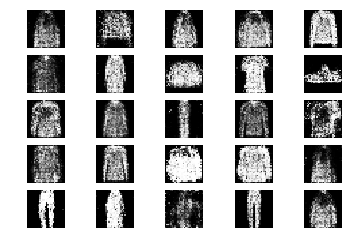

8001 [D loss: 0.675564, acc.: 56.00%] [G loss: 0.888295]
8002 [D loss: 0.713245, acc.: 54.00%] [G loss: 0.792224]
8003 [D loss: 0.698934, acc.: 53.00%] [G loss: 0.775889]
8004 [D loss: 0.675641, acc.: 58.00%] [G loss: 0.846202]
8005 [D loss: 0.641659, acc.: 60.00%] [G loss: 0.910186]
8006 [D loss: 0.668619, acc.: 63.00%] [G loss: 0.907776]
8007 [D loss: 0.757774, acc.: 45.00%] [G loss: 0.858679]
8008 [D loss: 0.726189, acc.: 51.00%] [G loss: 0.834178]
8009 [D loss: 0.600571, acc.: 68.00%] [G loss: 0.911107]
8010 [D loss: 0.697180, acc.: 50.00%] [G loss: 0.822208]
8011 [D loss: 0.661897, acc.: 62.00%] [G loss: 0.938563]
8012 [D loss: 0.685601, acc.: 61.00%] [G loss: 0.868922]
8013 [D loss: 0.685649, acc.: 56.00%] [G loss: 0.888764]
8014 [D loss: 0.662810, acc.: 62.00%] [G loss: 0.869178]
8015 [D loss: 0.610908, acc.: 69.00%] [G loss: 0.851578]
8016 [D loss: 0.686005, acc.: 56.00%] [G loss: 0.929447]
8017 [D loss: 0.647646, acc.: 56.00%] [G loss: 0.940597]
8018 [D loss: 0.693317, acc.: 5

8145 [D loss: 0.677667, acc.: 63.00%] [G loss: 0.922985]
8146 [D loss: 0.655364, acc.: 62.00%] [G loss: 0.923153]
8147 [D loss: 0.626551, acc.: 66.00%] [G loss: 0.906521]
8148 [D loss: 0.690776, acc.: 51.00%] [G loss: 0.858195]
8149 [D loss: 0.707372, acc.: 53.00%] [G loss: 0.885903]
8150 [D loss: 0.685418, acc.: 55.00%] [G loss: 0.929170]
8151 [D loss: 0.670256, acc.: 58.00%] [G loss: 0.856388]
8152 [D loss: 0.666048, acc.: 58.00%] [G loss: 0.849800]
8153 [D loss: 0.670262, acc.: 60.00%] [G loss: 0.894278]
8154 [D loss: 0.650048, acc.: 66.00%] [G loss: 0.870891]
8155 [D loss: 0.648118, acc.: 66.00%] [G loss: 0.883376]
8156 [D loss: 0.665112, acc.: 62.00%] [G loss: 0.829132]
8157 [D loss: 0.650114, acc.: 62.00%] [G loss: 0.947058]
8158 [D loss: 0.627574, acc.: 69.00%] [G loss: 0.871562]
8159 [D loss: 0.636479, acc.: 63.00%] [G loss: 0.816957]
8160 [D loss: 0.588386, acc.: 69.00%] [G loss: 0.878142]
8161 [D loss: 0.661821, acc.: 64.00%] [G loss: 0.875351]
8162 [D loss: 0.683303, acc.: 5

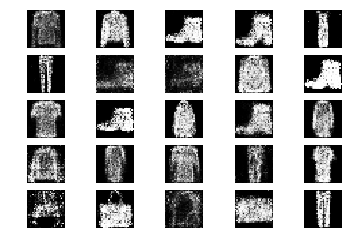

8201 [D loss: 0.662936, acc.: 58.00%] [G loss: 0.938562]
8202 [D loss: 0.690131, acc.: 56.00%] [G loss: 0.893589]
8203 [D loss: 0.672652, acc.: 60.00%] [G loss: 0.848260]
8204 [D loss: 0.694515, acc.: 57.00%] [G loss: 0.860644]
8205 [D loss: 0.681000, acc.: 56.00%] [G loss: 0.862310]
8206 [D loss: 0.723730, acc.: 56.00%] [G loss: 0.848859]
8207 [D loss: 0.659988, acc.: 58.00%] [G loss: 0.897701]
8208 [D loss: 0.676883, acc.: 53.00%] [G loss: 0.889298]
8209 [D loss: 0.664266, acc.: 64.00%] [G loss: 0.882542]
8210 [D loss: 0.671284, acc.: 58.00%] [G loss: 0.866206]
8211 [D loss: 0.682772, acc.: 55.00%] [G loss: 0.887423]
8212 [D loss: 0.628233, acc.: 69.00%] [G loss: 0.906018]
8213 [D loss: 0.691020, acc.: 55.00%] [G loss: 0.855175]
8214 [D loss: 0.683647, acc.: 55.00%] [G loss: 0.889261]
8215 [D loss: 0.637488, acc.: 65.00%] [G loss: 0.883565]
8216 [D loss: 0.713791, acc.: 48.00%] [G loss: 0.894286]
8217 [D loss: 0.702750, acc.: 47.00%] [G loss: 0.872254]
8218 [D loss: 0.675401, acc.: 5

8345 [D loss: 0.633951, acc.: 59.00%] [G loss: 0.832606]
8346 [D loss: 0.668357, acc.: 59.00%] [G loss: 0.859348]
8347 [D loss: 0.647531, acc.: 62.00%] [G loss: 0.900508]
8348 [D loss: 0.678782, acc.: 61.00%] [G loss: 0.856660]
8349 [D loss: 0.638887, acc.: 62.00%] [G loss: 0.940921]
8350 [D loss: 0.637778, acc.: 67.00%] [G loss: 0.890255]
8351 [D loss: 0.672257, acc.: 51.00%] [G loss: 0.817611]
8352 [D loss: 0.653055, acc.: 55.00%] [G loss: 0.807563]
8353 [D loss: 0.623506, acc.: 61.00%] [G loss: 0.850696]
8354 [D loss: 0.657209, acc.: 56.00%] [G loss: 0.857892]
8355 [D loss: 0.693675, acc.: 55.00%] [G loss: 0.936296]
8356 [D loss: 0.684422, acc.: 56.00%] [G loss: 0.894061]
8357 [D loss: 0.658758, acc.: 57.00%] [G loss: 0.889346]
8358 [D loss: 0.685025, acc.: 55.00%] [G loss: 0.908867]
8359 [D loss: 0.660471, acc.: 63.00%] [G loss: 0.891014]
8360 [D loss: 0.660579, acc.: 63.00%] [G loss: 0.872109]
8361 [D loss: 0.695275, acc.: 55.00%] [G loss: 0.899339]
8362 [D loss: 0.670457, acc.: 5

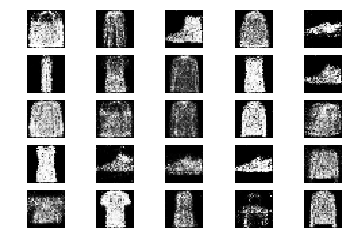

8401 [D loss: 0.678558, acc.: 61.00%] [G loss: 0.854944]
8402 [D loss: 0.678682, acc.: 55.00%] [G loss: 0.863251]
8403 [D loss: 0.698129, acc.: 52.00%] [G loss: 0.816185]
8404 [D loss: 0.668198, acc.: 59.00%] [G loss: 0.841198]
8405 [D loss: 0.684519, acc.: 54.00%] [G loss: 0.821642]
8406 [D loss: 0.681394, acc.: 52.00%] [G loss: 0.823921]
8407 [D loss: 0.678866, acc.: 55.00%] [G loss: 0.786565]
8408 [D loss: 0.629947, acc.: 65.00%] [G loss: 0.770721]
8409 [D loss: 0.691852, acc.: 59.00%] [G loss: 0.769838]
8410 [D loss: 0.676881, acc.: 52.00%] [G loss: 0.858654]
8411 [D loss: 0.657800, acc.: 63.00%] [G loss: 0.820869]
8412 [D loss: 0.634339, acc.: 62.00%] [G loss: 0.822507]
8413 [D loss: 0.653861, acc.: 59.00%] [G loss: 0.860272]
8414 [D loss: 0.636125, acc.: 63.00%] [G loss: 0.857458]
8415 [D loss: 0.677558, acc.: 61.00%] [G loss: 0.882767]
8416 [D loss: 0.697559, acc.: 49.00%] [G loss: 0.876975]
8417 [D loss: 0.627028, acc.: 65.00%] [G loss: 0.910656]
8418 [D loss: 0.636925, acc.: 5

8545 [D loss: 0.709358, acc.: 59.00%] [G loss: 0.848492]
8546 [D loss: 0.666659, acc.: 58.00%] [G loss: 0.836818]
8547 [D loss: 0.683928, acc.: 54.00%] [G loss: 0.838404]
8548 [D loss: 0.637996, acc.: 62.00%] [G loss: 0.846814]
8549 [D loss: 0.684034, acc.: 50.00%] [G loss: 0.901356]
8550 [D loss: 0.686610, acc.: 51.00%] [G loss: 0.923199]
8551 [D loss: 0.633102, acc.: 63.00%] [G loss: 0.964715]
8552 [D loss: 0.689227, acc.: 58.00%] [G loss: 0.901845]
8553 [D loss: 0.687712, acc.: 61.00%] [G loss: 0.878092]
8554 [D loss: 0.705838, acc.: 53.00%] [G loss: 0.924691]
8555 [D loss: 0.642690, acc.: 65.00%] [G loss: 0.881637]
8556 [D loss: 0.610817, acc.: 74.00%] [G loss: 0.801898]
8557 [D loss: 0.637207, acc.: 60.00%] [G loss: 0.848360]
8558 [D loss: 0.665881, acc.: 57.00%] [G loss: 0.812769]
8559 [D loss: 0.640038, acc.: 65.00%] [G loss: 0.870537]
8560 [D loss: 0.622412, acc.: 70.00%] [G loss: 0.816289]
8561 [D loss: 0.659168, acc.: 55.00%] [G loss: 0.867940]
8562 [D loss: 0.728273, acc.: 5

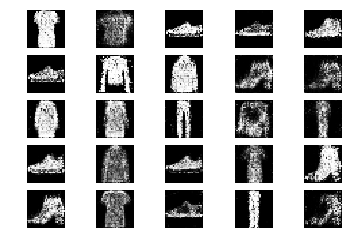

8601 [D loss: 0.686063, acc.: 54.00%] [G loss: 0.920232]
8602 [D loss: 0.697983, acc.: 52.00%] [G loss: 0.768702]
8603 [D loss: 0.662112, acc.: 67.00%] [G loss: 0.859331]
8604 [D loss: 0.632822, acc.: 62.00%] [G loss: 0.853827]
8605 [D loss: 0.676055, acc.: 53.00%] [G loss: 0.867599]
8606 [D loss: 0.682728, acc.: 59.00%] [G loss: 0.824177]
8607 [D loss: 0.660090, acc.: 56.00%] [G loss: 0.896706]
8608 [D loss: 0.681144, acc.: 58.00%] [G loss: 0.818772]
8609 [D loss: 0.662471, acc.: 61.00%] [G loss: 0.846941]
8610 [D loss: 0.689020, acc.: 53.00%] [G loss: 0.817181]
8611 [D loss: 0.632903, acc.: 72.00%] [G loss: 0.868093]
8612 [D loss: 0.671517, acc.: 60.00%] [G loss: 0.829423]
8613 [D loss: 0.698342, acc.: 52.00%] [G loss: 0.842724]
8614 [D loss: 0.684276, acc.: 57.00%] [G loss: 0.894387]
8615 [D loss: 0.664943, acc.: 60.00%] [G loss: 0.889124]
8616 [D loss: 0.628564, acc.: 64.00%] [G loss: 0.924634]
8617 [D loss: 0.724717, acc.: 51.00%] [G loss: 0.907759]
8618 [D loss: 0.669909, acc.: 5

8745 [D loss: 0.646450, acc.: 64.00%] [G loss: 0.899145]
8746 [D loss: 0.664265, acc.: 58.00%] [G loss: 0.899497]
8747 [D loss: 0.677728, acc.: 58.00%] [G loss: 0.862649]
8748 [D loss: 0.654269, acc.: 61.00%] [G loss: 0.883431]
8749 [D loss: 0.670009, acc.: 59.00%] [G loss: 0.834890]
8750 [D loss: 0.662434, acc.: 59.00%] [G loss: 0.852354]
8751 [D loss: 0.693618, acc.: 46.00%] [G loss: 0.911797]
8752 [D loss: 0.686514, acc.: 54.00%] [G loss: 0.849748]
8753 [D loss: 0.642616, acc.: 61.00%] [G loss: 0.902808]
8754 [D loss: 0.625041, acc.: 70.00%] [G loss: 0.894457]
8755 [D loss: 0.610127, acc.: 67.00%] [G loss: 0.833822]
8756 [D loss: 0.651549, acc.: 65.00%] [G loss: 0.849167]
8757 [D loss: 0.681180, acc.: 62.00%] [G loss: 0.895403]
8758 [D loss: 0.719223, acc.: 45.00%] [G loss: 0.859198]
8759 [D loss: 0.640087, acc.: 74.00%] [G loss: 0.910095]
8760 [D loss: 0.691446, acc.: 56.00%] [G loss: 0.876999]
8761 [D loss: 0.609092, acc.: 68.00%] [G loss: 0.873415]
8762 [D loss: 0.685441, acc.: 5

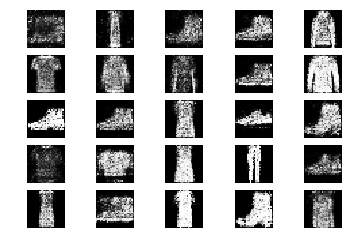

8801 [D loss: 0.680425, acc.: 55.00%] [G loss: 0.854238]
8802 [D loss: 0.659963, acc.: 59.00%] [G loss: 0.863842]
8803 [D loss: 0.692300, acc.: 57.00%] [G loss: 0.891133]
8804 [D loss: 0.669059, acc.: 62.00%] [G loss: 0.868953]
8805 [D loss: 0.699747, acc.: 53.00%] [G loss: 0.885949]
8806 [D loss: 0.683114, acc.: 61.00%] [G loss: 0.878849]
8807 [D loss: 0.611000, acc.: 68.00%] [G loss: 0.878654]
8808 [D loss: 0.673020, acc.: 58.00%] [G loss: 0.847396]
8809 [D loss: 0.661553, acc.: 51.00%] [G loss: 0.855502]
8810 [D loss: 0.676826, acc.: 61.00%] [G loss: 0.930590]
8811 [D loss: 0.645773, acc.: 62.00%] [G loss: 0.894084]
8812 [D loss: 0.683769, acc.: 60.00%] [G loss: 0.870840]
8813 [D loss: 0.665634, acc.: 58.00%] [G loss: 0.855915]
8814 [D loss: 0.603820, acc.: 70.00%] [G loss: 0.877182]
8815 [D loss: 0.689210, acc.: 55.00%] [G loss: 0.814174]
8816 [D loss: 0.635259, acc.: 65.00%] [G loss: 0.841954]
8817 [D loss: 0.629841, acc.: 67.00%] [G loss: 0.967993]
8818 [D loss: 0.631149, acc.: 6

8945 [D loss: 0.633697, acc.: 66.00%] [G loss: 0.860958]
8946 [D loss: 0.646934, acc.: 63.00%] [G loss: 0.951688]
8947 [D loss: 0.700374, acc.: 58.00%] [G loss: 0.920449]
8948 [D loss: 0.641526, acc.: 63.00%] [G loss: 0.911874]
8949 [D loss: 0.683704, acc.: 55.00%] [G loss: 0.903697]
8950 [D loss: 0.646781, acc.: 62.00%] [G loss: 0.901618]
8951 [D loss: 0.698087, acc.: 52.00%] [G loss: 0.922383]
8952 [D loss: 0.656921, acc.: 59.00%] [G loss: 0.910239]
8953 [D loss: 0.644849, acc.: 63.00%] [G loss: 0.899625]
8954 [D loss: 0.695586, acc.: 55.00%] [G loss: 0.976640]
8955 [D loss: 0.635626, acc.: 73.00%] [G loss: 0.892495]
8956 [D loss: 0.624370, acc.: 63.00%] [G loss: 0.899716]
8957 [D loss: 0.678093, acc.: 62.00%] [G loss: 0.873616]
8958 [D loss: 0.658629, acc.: 61.00%] [G loss: 0.902109]
8959 [D loss: 0.664468, acc.: 60.00%] [G loss: 0.896772]
8960 [D loss: 0.635444, acc.: 68.00%] [G loss: 0.857348]
8961 [D loss: 0.644279, acc.: 62.00%] [G loss: 0.886968]
8962 [D loss: 0.679269, acc.: 6

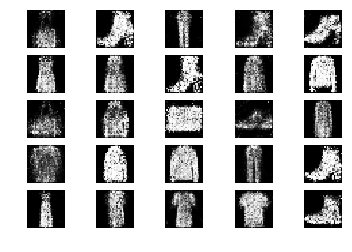

9001 [D loss: 0.689836, acc.: 56.00%] [G loss: 0.841271]
9002 [D loss: 0.680790, acc.: 53.00%] [G loss: 0.885360]
9003 [D loss: 0.640878, acc.: 65.00%] [G loss: 0.841429]
9004 [D loss: 0.649105, acc.: 63.00%] [G loss: 0.843429]
9005 [D loss: 0.664048, acc.: 63.00%] [G loss: 0.869656]
9006 [D loss: 0.674676, acc.: 60.00%] [G loss: 0.861126]
9007 [D loss: 0.676048, acc.: 57.00%] [G loss: 0.809884]
9008 [D loss: 0.666476, acc.: 61.00%] [G loss: 0.858083]
9009 [D loss: 0.639687, acc.: 70.00%] [G loss: 0.849113]
9010 [D loss: 0.639002, acc.: 64.00%] [G loss: 0.883959]
9011 [D loss: 0.679404, acc.: 57.00%] [G loss: 0.841659]
9012 [D loss: 0.648143, acc.: 62.00%] [G loss: 0.804656]
9013 [D loss: 0.664775, acc.: 61.00%] [G loss: 0.865769]
9014 [D loss: 0.704205, acc.: 54.00%] [G loss: 0.778226]
9015 [D loss: 0.648602, acc.: 65.00%] [G loss: 0.835975]
9016 [D loss: 0.682877, acc.: 60.00%] [G loss: 0.848085]
9017 [D loss: 0.673631, acc.: 56.00%] [G loss: 0.786319]
9018 [D loss: 0.690118, acc.: 5

9146 [D loss: 0.655144, acc.: 65.00%] [G loss: 0.894890]
9147 [D loss: 0.650260, acc.: 65.00%] [G loss: 0.827692]
9148 [D loss: 0.695132, acc.: 55.00%] [G loss: 0.876487]
9149 [D loss: 0.652485, acc.: 60.00%] [G loss: 0.844641]
9150 [D loss: 0.634175, acc.: 62.00%] [G loss: 0.842666]
9151 [D loss: 0.648281, acc.: 59.00%] [G loss: 0.858146]
9152 [D loss: 0.658594, acc.: 51.00%] [G loss: 0.872121]
9153 [D loss: 0.658138, acc.: 63.00%] [G loss: 0.909598]
9154 [D loss: 0.707235, acc.: 57.00%] [G loss: 0.885158]
9155 [D loss: 0.715022, acc.: 47.00%] [G loss: 0.902699]
9156 [D loss: 0.649586, acc.: 61.00%] [G loss: 0.930055]
9157 [D loss: 0.690970, acc.: 57.00%] [G loss: 0.866898]
9158 [D loss: 0.676685, acc.: 64.00%] [G loss: 0.837810]
9159 [D loss: 0.676033, acc.: 49.00%] [G loss: 0.879207]
9160 [D loss: 0.637443, acc.: 65.00%] [G loss: 0.929410]
9161 [D loss: 0.707231, acc.: 50.00%] [G loss: 0.952196]
9162 [D loss: 0.732487, acc.: 50.00%] [G loss: 0.877983]
9163 [D loss: 0.655844, acc.: 6

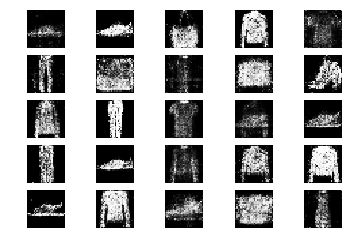

9201 [D loss: 0.621349, acc.: 65.00%] [G loss: 0.959251]
9202 [D loss: 0.672339, acc.: 62.00%] [G loss: 0.895426]
9203 [D loss: 0.605717, acc.: 69.00%] [G loss: 0.883834]
9204 [D loss: 0.607075, acc.: 68.00%] [G loss: 0.934254]
9205 [D loss: 0.598289, acc.: 71.00%] [G loss: 0.917349]
9206 [D loss: 0.615491, acc.: 63.00%] [G loss: 0.934555]
9207 [D loss: 0.635374, acc.: 61.00%] [G loss: 0.838815]
9208 [D loss: 0.630850, acc.: 60.00%] [G loss: 0.867519]
9209 [D loss: 0.628411, acc.: 66.00%] [G loss: 0.875946]
9210 [D loss: 0.712098, acc.: 55.00%] [G loss: 0.832826]
9211 [D loss: 0.692436, acc.: 56.00%] [G loss: 0.871906]
9212 [D loss: 0.686298, acc.: 59.00%] [G loss: 0.859423]
9213 [D loss: 0.648685, acc.: 60.00%] [G loss: 0.873606]
9214 [D loss: 0.686394, acc.: 58.00%] [G loss: 0.936728]
9215 [D loss: 0.666994, acc.: 56.00%] [G loss: 0.901210]
9216 [D loss: 0.732470, acc.: 52.00%] [G loss: 0.906260]
9217 [D loss: 0.667500, acc.: 66.00%] [G loss: 0.900783]
9218 [D loss: 0.668005, acc.: 5

9346 [D loss: 0.679458, acc.: 55.00%] [G loss: 0.899658]
9347 [D loss: 0.718695, acc.: 48.00%] [G loss: 0.872155]
9348 [D loss: 0.664696, acc.: 58.00%] [G loss: 0.921091]
9349 [D loss: 0.648733, acc.: 62.00%] [G loss: 0.889073]
9350 [D loss: 0.643311, acc.: 69.00%] [G loss: 0.900905]
9351 [D loss: 0.698586, acc.: 61.00%] [G loss: 0.852760]
9352 [D loss: 0.706589, acc.: 57.00%] [G loss: 0.874088]
9353 [D loss: 0.664433, acc.: 56.00%] [G loss: 0.793076]
9354 [D loss: 0.664609, acc.: 64.00%] [G loss: 0.836626]
9355 [D loss: 0.704475, acc.: 52.00%] [G loss: 0.825782]
9356 [D loss: 0.641949, acc.: 63.00%] [G loss: 0.943842]
9357 [D loss: 0.662366, acc.: 56.00%] [G loss: 0.906995]
9358 [D loss: 0.654786, acc.: 60.00%] [G loss: 0.941803]
9359 [D loss: 0.676661, acc.: 59.00%] [G loss: 0.896576]
9360 [D loss: 0.667305, acc.: 59.00%] [G loss: 0.920148]
9361 [D loss: 0.677078, acc.: 53.00%] [G loss: 0.840729]
9362 [D loss: 0.679602, acc.: 55.00%] [G loss: 0.873188]
9363 [D loss: 0.606161, acc.: 7

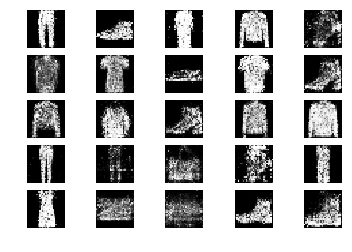

9401 [D loss: 0.625042, acc.: 68.00%] [G loss: 0.919129]
9402 [D loss: 0.672263, acc.: 58.00%] [G loss: 0.817264]
9403 [D loss: 0.631893, acc.: 66.00%] [G loss: 0.874922]
9404 [D loss: 0.611986, acc.: 74.00%] [G loss: 0.853580]
9405 [D loss: 0.739614, acc.: 51.00%] [G loss: 0.828826]
9406 [D loss: 0.679168, acc.: 48.00%] [G loss: 0.866896]
9407 [D loss: 0.689918, acc.: 58.00%] [G loss: 0.876643]
9408 [D loss: 0.679031, acc.: 59.00%] [G loss: 0.869876]
9409 [D loss: 0.637156, acc.: 66.00%] [G loss: 0.875933]
9410 [D loss: 0.691223, acc.: 61.00%] [G loss: 0.832652]
9411 [D loss: 0.660035, acc.: 58.00%] [G loss: 0.831909]
9412 [D loss: 0.670113, acc.: 59.00%] [G loss: 0.867775]
9413 [D loss: 0.672772, acc.: 59.00%] [G loss: 0.855131]
9414 [D loss: 0.700865, acc.: 52.00%] [G loss: 0.861162]
9415 [D loss: 0.604034, acc.: 73.00%] [G loss: 0.889594]
9416 [D loss: 0.651962, acc.: 64.00%] [G loss: 0.918436]
9417 [D loss: 0.705494, acc.: 48.00%] [G loss: 0.864282]
9418 [D loss: 0.627729, acc.: 6

9546 [D loss: 0.666940, acc.: 67.00%] [G loss: 0.871434]
9547 [D loss: 0.680851, acc.: 53.00%] [G loss: 0.847344]
9548 [D loss: 0.649786, acc.: 59.00%] [G loss: 0.805953]
9549 [D loss: 0.722062, acc.: 53.00%] [G loss: 0.867429]
9550 [D loss: 0.616054, acc.: 67.00%] [G loss: 0.864466]
9551 [D loss: 0.689034, acc.: 61.00%] [G loss: 0.919507]
9552 [D loss: 0.669564, acc.: 61.00%] [G loss: 0.901878]
9553 [D loss: 0.624673, acc.: 60.00%] [G loss: 0.912315]
9554 [D loss: 0.651974, acc.: 57.00%] [G loss: 0.825927]
9555 [D loss: 0.650165, acc.: 58.00%] [G loss: 0.873337]
9556 [D loss: 0.642704, acc.: 65.00%] [G loss: 0.892459]
9557 [D loss: 0.689759, acc.: 56.00%] [G loss: 0.852044]
9558 [D loss: 0.663146, acc.: 63.00%] [G loss: 0.848151]
9559 [D loss: 0.655275, acc.: 59.00%] [G loss: 0.885053]
9560 [D loss: 0.664354, acc.: 68.00%] [G loss: 0.867720]
9561 [D loss: 0.682690, acc.: 57.00%] [G loss: 0.860847]
9562 [D loss: 0.685549, acc.: 58.00%] [G loss: 0.882840]
9563 [D loss: 0.678171, acc.: 5

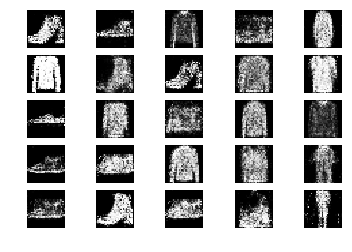

9601 [D loss: 0.693447, acc.: 60.00%] [G loss: 0.915433]
9602 [D loss: 0.648438, acc.: 64.00%] [G loss: 0.893949]
9603 [D loss: 0.627253, acc.: 65.00%] [G loss: 0.827677]
9604 [D loss: 0.645622, acc.: 65.00%] [G loss: 0.865674]
9605 [D loss: 0.678612, acc.: 53.00%] [G loss: 0.851093]
9606 [D loss: 0.696449, acc.: 51.00%] [G loss: 0.812037]
9607 [D loss: 0.616984, acc.: 67.00%] [G loss: 0.879784]
9608 [D loss: 0.634090, acc.: 64.00%] [G loss: 0.879559]
9609 [D loss: 0.689742, acc.: 53.00%] [G loss: 0.881935]
9610 [D loss: 0.672735, acc.: 57.00%] [G loss: 0.867019]
9611 [D loss: 0.687801, acc.: 54.00%] [G loss: 0.854842]
9612 [D loss: 0.627610, acc.: 63.00%] [G loss: 0.900573]
9613 [D loss: 0.669780, acc.: 56.00%] [G loss: 0.861943]
9614 [D loss: 0.681111, acc.: 55.00%] [G loss: 0.830729]
9615 [D loss: 0.637648, acc.: 64.00%] [G loss: 0.894805]
9616 [D loss: 0.611826, acc.: 69.00%] [G loss: 0.893433]
9617 [D loss: 0.644752, acc.: 62.00%] [G loss: 0.969945]
9618 [D loss: 0.679115, acc.: 5

9745 [D loss: 0.670354, acc.: 60.00%] [G loss: 0.878195]
9746 [D loss: 0.625719, acc.: 68.00%] [G loss: 0.956574]
9747 [D loss: 0.638219, acc.: 67.00%] [G loss: 0.858915]
9748 [D loss: 0.686468, acc.: 59.00%] [G loss: 0.892401]
9749 [D loss: 0.663718, acc.: 60.00%] [G loss: 0.898569]
9750 [D loss: 0.665261, acc.: 66.00%] [G loss: 0.882581]
9751 [D loss: 0.642494, acc.: 62.00%] [G loss: 0.936327]
9752 [D loss: 0.637486, acc.: 68.00%] [G loss: 0.848533]
9753 [D loss: 0.664400, acc.: 56.00%] [G loss: 0.858616]
9754 [D loss: 0.649349, acc.: 56.00%] [G loss: 0.820850]
9755 [D loss: 0.650629, acc.: 58.00%] [G loss: 0.888681]
9756 [D loss: 0.679553, acc.: 57.00%] [G loss: 0.906342]
9757 [D loss: 0.652100, acc.: 60.00%] [G loss: 0.893433]
9758 [D loss: 0.648310, acc.: 67.00%] [G loss: 0.902509]
9759 [D loss: 0.693142, acc.: 54.00%] [G loss: 0.896722]
9760 [D loss: 0.687500, acc.: 56.00%] [G loss: 0.812464]
9761 [D loss: 0.659347, acc.: 57.00%] [G loss: 0.829930]
9762 [D loss: 0.679258, acc.: 5

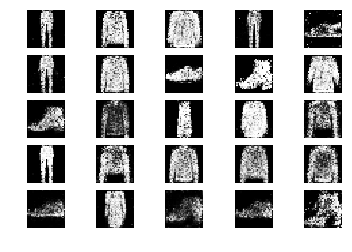

9801 [D loss: 0.658303, acc.: 63.00%] [G loss: 0.902161]
9802 [D loss: 0.646055, acc.: 60.00%] [G loss: 0.899590]
9803 [D loss: 0.667222, acc.: 62.00%] [G loss: 0.922740]
9804 [D loss: 0.675793, acc.: 56.00%] [G loss: 0.880681]
9805 [D loss: 0.676153, acc.: 59.00%] [G loss: 0.817805]
9806 [D loss: 0.631282, acc.: 72.00%] [G loss: 0.938256]
9807 [D loss: 0.645585, acc.: 63.00%] [G loss: 0.883545]
9808 [D loss: 0.651206, acc.: 61.00%] [G loss: 0.837817]
9809 [D loss: 0.657622, acc.: 59.00%] [G loss: 0.903023]
9810 [D loss: 0.665562, acc.: 62.00%] [G loss: 0.871971]
9811 [D loss: 0.634962, acc.: 65.00%] [G loss: 0.814491]
9812 [D loss: 0.642784, acc.: 62.00%] [G loss: 0.824412]
9813 [D loss: 0.661449, acc.: 63.00%] [G loss: 0.824547]
9814 [D loss: 0.656020, acc.: 62.00%] [G loss: 0.864021]
9815 [D loss: 0.681733, acc.: 59.00%] [G loss: 0.880557]
9816 [D loss: 0.614957, acc.: 68.00%] [G loss: 0.863931]
9817 [D loss: 0.692984, acc.: 55.00%] [G loss: 0.896223]
9818 [D loss: 0.619572, acc.: 7

9945 [D loss: 0.700006, acc.: 51.00%] [G loss: 0.905448]
9946 [D loss: 0.667580, acc.: 57.00%] [G loss: 0.840593]
9947 [D loss: 0.643910, acc.: 65.00%] [G loss: 0.895914]
9948 [D loss: 0.698117, acc.: 58.00%] [G loss: 0.904749]
9949 [D loss: 0.697234, acc.: 47.00%] [G loss: 0.916097]
9950 [D loss: 0.653252, acc.: 59.00%] [G loss: 0.911300]
9951 [D loss: 0.664973, acc.: 65.00%] [G loss: 0.884211]
9952 [D loss: 0.634134, acc.: 58.00%] [G loss: 0.908816]
9953 [D loss: 0.684192, acc.: 52.00%] [G loss: 0.963484]
9954 [D loss: 0.699582, acc.: 53.00%] [G loss: 0.912437]
9955 [D loss: 0.686823, acc.: 57.00%] [G loss: 0.953435]
9956 [D loss: 0.619754, acc.: 69.00%] [G loss: 0.886972]
9957 [D loss: 0.687212, acc.: 59.00%] [G loss: 0.826649]
9958 [D loss: 0.697751, acc.: 53.00%] [G loss: 0.819636]
9959 [D loss: 0.676792, acc.: 56.00%] [G loss: 0.832402]
9960 [D loss: 0.663436, acc.: 59.00%] [G loss: 0.846352]
9961 [D loss: 0.658147, acc.: 61.00%] [G loss: 0.800967]
9962 [D loss: 0.652001, acc.: 6

In [4]:
# In[ ]:


if __name__ == '__main__':
    gan = GAN()
    gan.train(epochs=10000, batch_size=50, sample_interval=200)